In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install pandas numpy matplotlib seaborn yfinance scipy statsmodels arch prophet scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.9 MB/s eta 0:00:00


In [4]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from arch import arch_model
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.optimize import minimize
from scipy.stats import t

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Step 1: Load data
df_raw = pd.read_csv("/content/drive/MyDrive/Stock Prediction/dataset.csv",
                     parse_dates=['Date'])

# Convert wide to long format manually
df_long = df_raw.melt(id_vars='Date', var_name='Ticker', value_name='Close')

# Plot


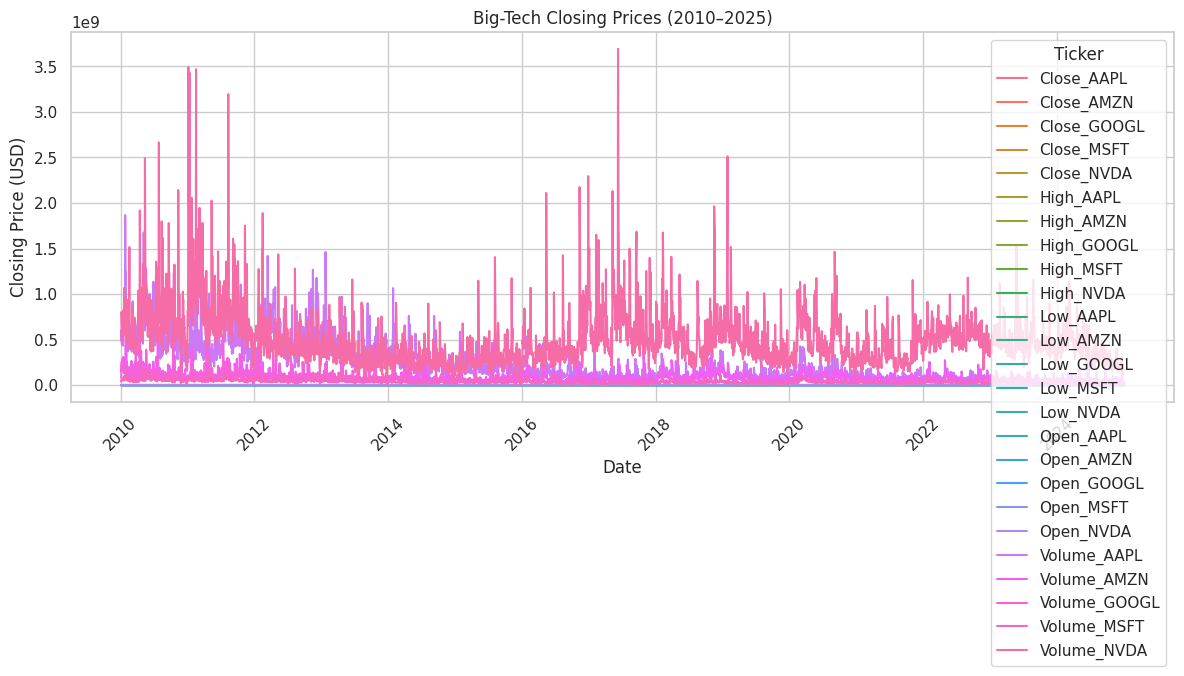

In [17]:
# Time-series plots
sns.lineplot(data=df_long, x='Date', y='Close', hue='Ticker')
plt.title('Big-Tech Closing Prices (2010–2025)')
plt.ylabel('Closing Price (USD)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


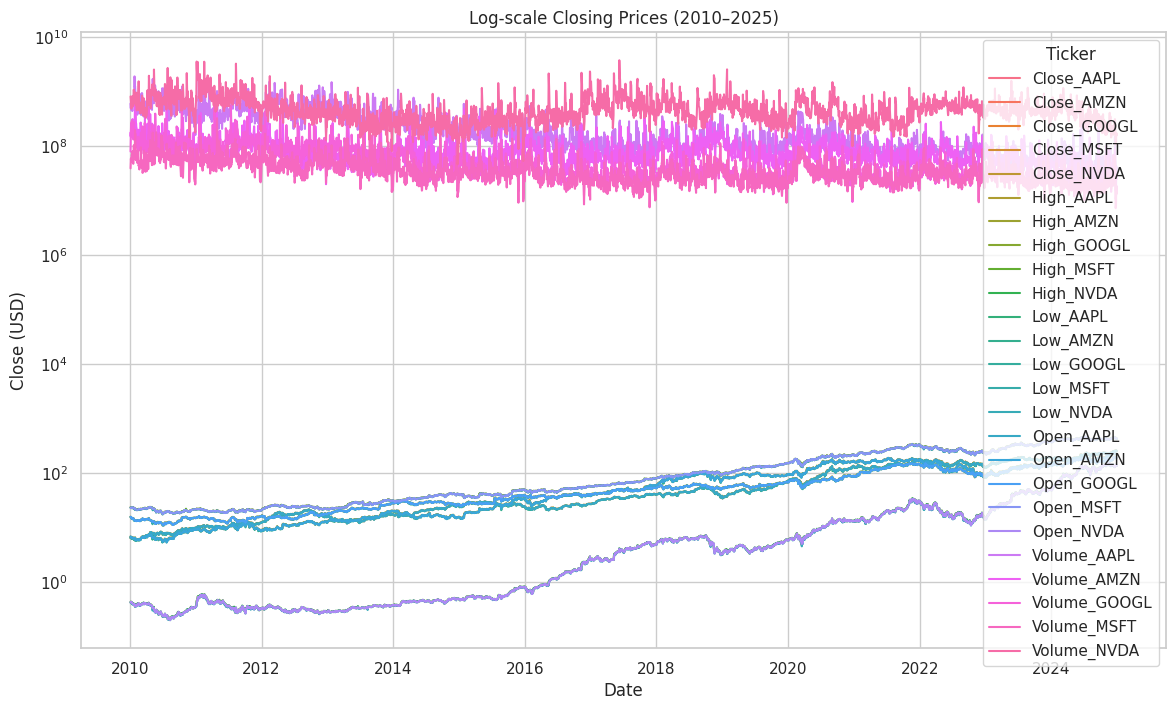

In [18]:
# Log-scaled plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x='Date', y='Close', hue='Ticker')
plt.yscale('log')
plt.title('Log-scale Closing Prices (2010–2025)')
plt.ylabel('Close (USD)')
plt.show()

In [11]:
summary = df_long.groupby('Ticker')['Close'].agg(['min', 'max', 'mean', 'std'])
print(summary)

                       min           max          mean           std
Ticker                                                              
Close_AAPL    5.779478e+00  2.587355e+02  6.752169e+01  6.560267e+01
Close_AMZN    5.430500e+00  2.329300e+02  7.144484e+01  6.112411e+01
Close_GOOGL   1.086074e+01  1.964338e+02  6.114978e+01  4.663836e+01
Close_MSFT    1.744761e+01  4.648543e+02  1.295783e+02  1.249879e+02
Close_NVDA    2.035743e-01  1.488561e+02  1.397760e+01  2.808826e+01
High_AAPL     5.898345e+00  2.598143e+02  6.817623e+01  6.621238e+01
High_AMZN     5.564500e+00  2.330000e+02  7.227216e+01  6.184300e+01
High_GOOGL    1.101540e+01  2.011883e+02  6.176288e+01  4.714431e+01
High_MSFT     1.768268e+01  4.656398e+02  1.307709e+02  1.261048e+02
High_NVDA     2.074715e-01  1.528654e+02  1.423144e+01  2.861067e+01
Low_AAPL      5.725307e+00  2.573470e+02  6.679725e+01  6.490410e+01
Low_AMZN      5.290000e+00  2.280100e+02  7.057450e+01  6.039173e+01
Low_GOOGL     1.079997e+01  1.9475

In [14]:
### Calculate log returns

df_returns = df_long.sort_values(['Ticker', 'Date']).copy()
df_returns['log_return'] = df_returns.groupby('Ticker')['Close'].transform(
    lambda x: np.log(x) - np.log(x.shift(1))
)
df_returns.dropna(inplace=True)


In [15]:
# Calculate 30-day rolling volatility
df_returns['vol30'] = df_returns.groupby('Ticker')['log_return'].transform(
    lambda x: x.rolling(window=30).std())

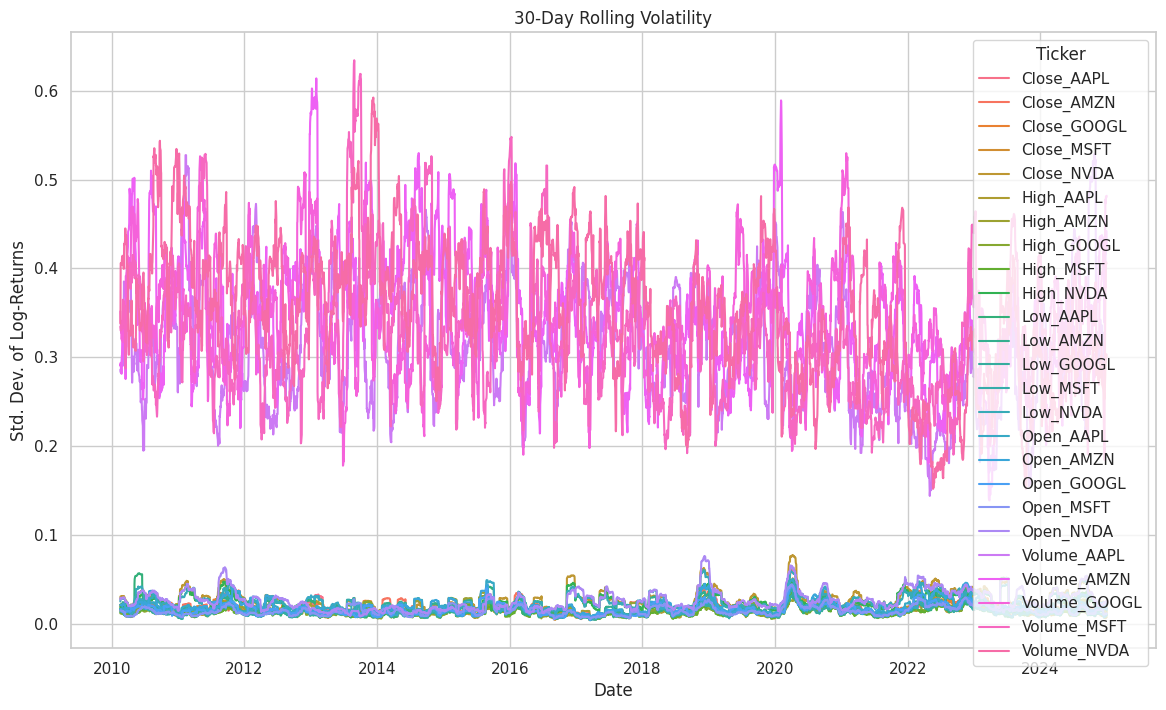

In [16]:
# Plot volatility
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_returns, x='Date', y='vol30', hue='Ticker')
plt.title('30-Day Rolling Volatility')
plt.ylabel('Std. Dev. of Log-Returns')
plt.show()


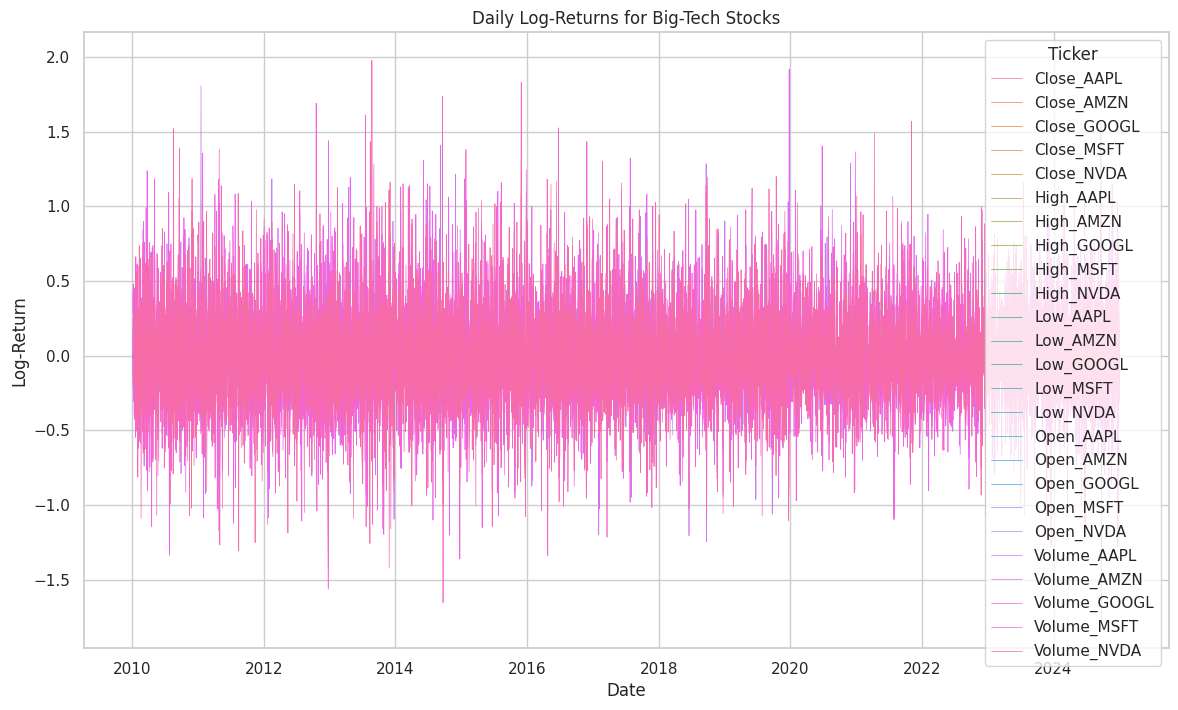

In [19]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_returns, x='Date', y='log_return', hue='Ticker', linewidth=0.5)
plt.title('Daily Log-Returns for Big-Tech Stocks')
plt.ylabel('Log-Return')
plt.show()

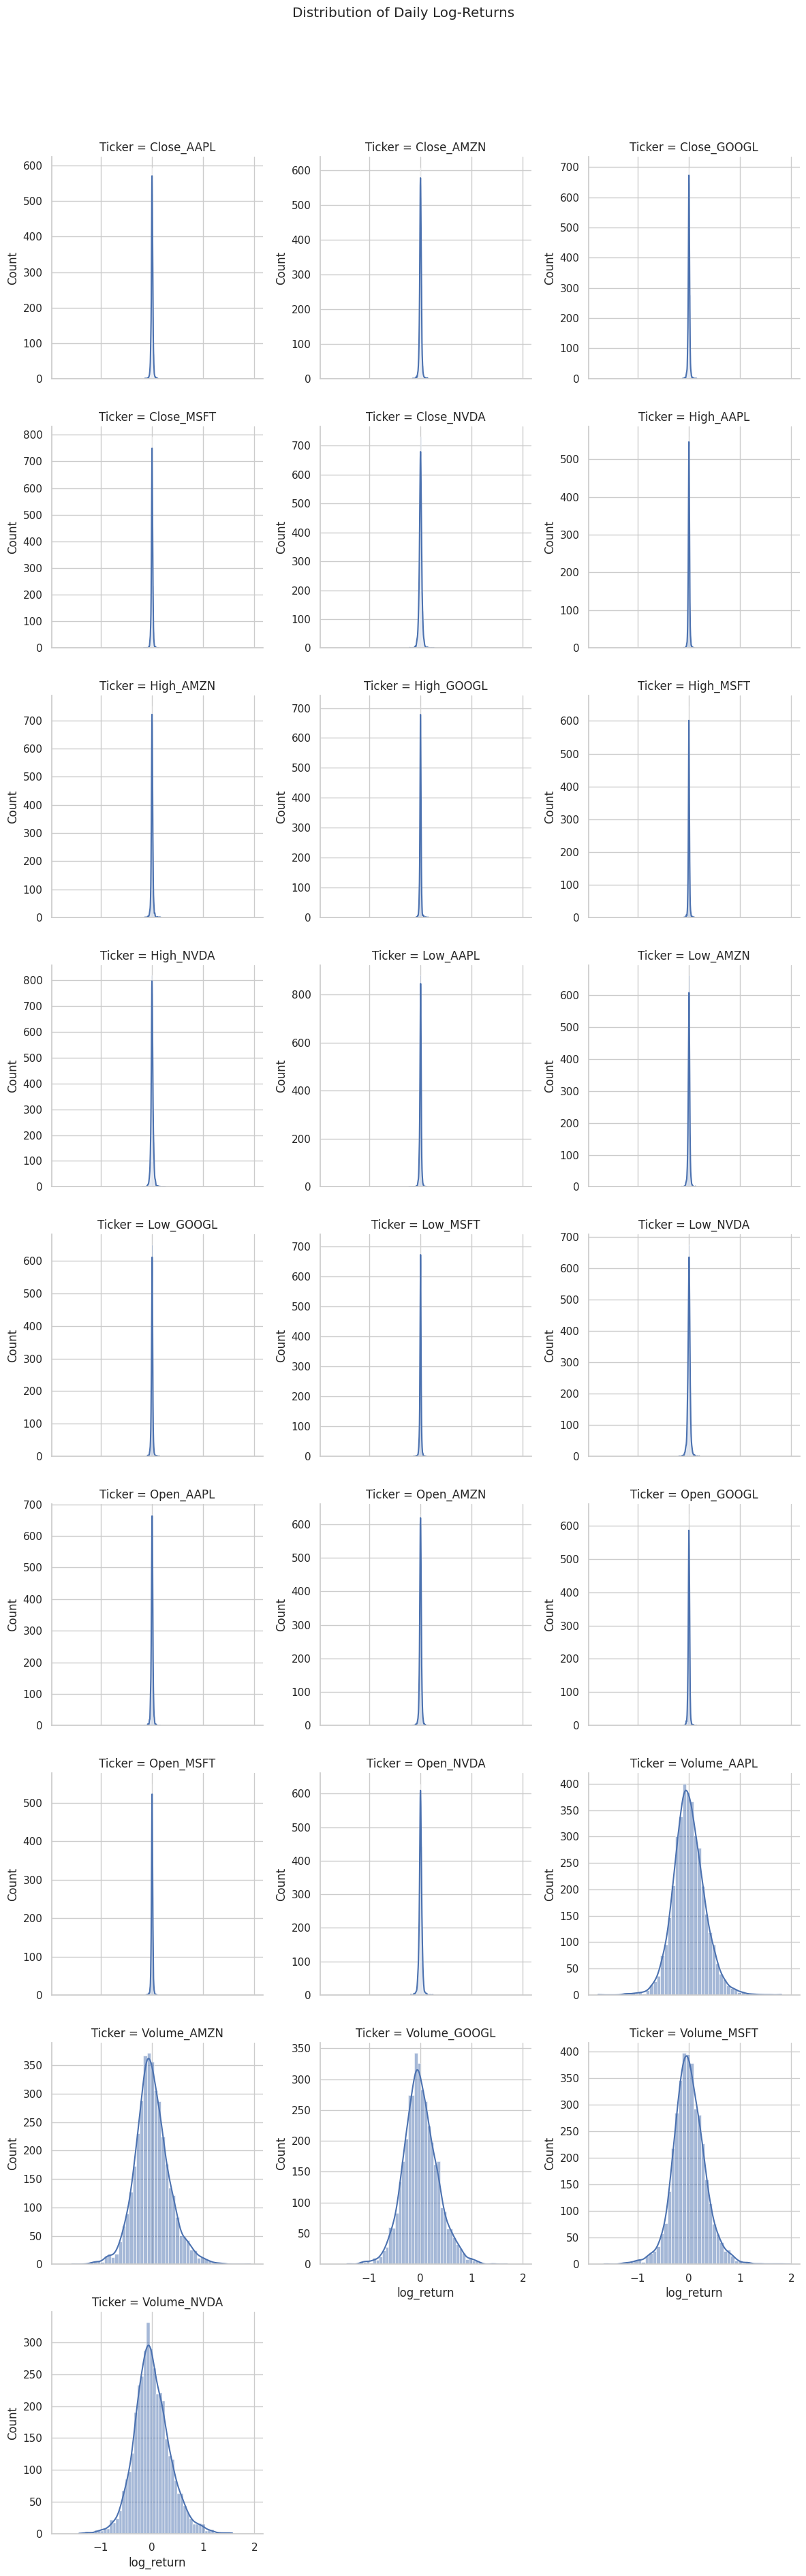

In [20]:
# Histograms of returns
g = sns.FacetGrid(df_returns, col='Ticker', col_wrap=3, height=4, sharey=False)
g.map(sns.histplot, 'log_return', bins=50, kde=True)
g.fig.suptitle('Distribution of Daily Log-Returns', y=1.05)
plt.show()

In [21]:
# Indexed close prices
df_norm = df_long.copy()
df_norm['idx_close'] = df_norm.groupby('Ticker')['Close'].transform(
    lambda x: x / x.iloc[0] * 100)

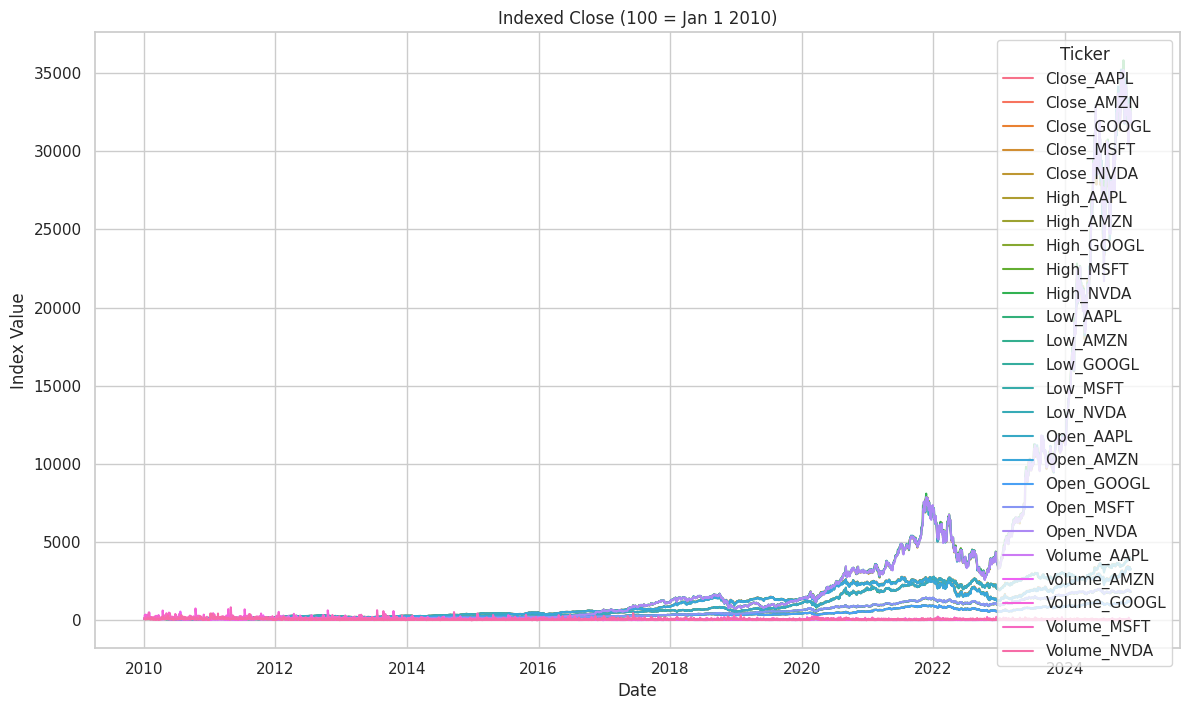

In [22]:
# Plot indexed prices
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_norm, x='Date', y='idx_close', hue='Ticker')
plt.title('Indexed Close (100 = Jan 1 2010)')
plt.ylabel('Index Value')
plt.show()


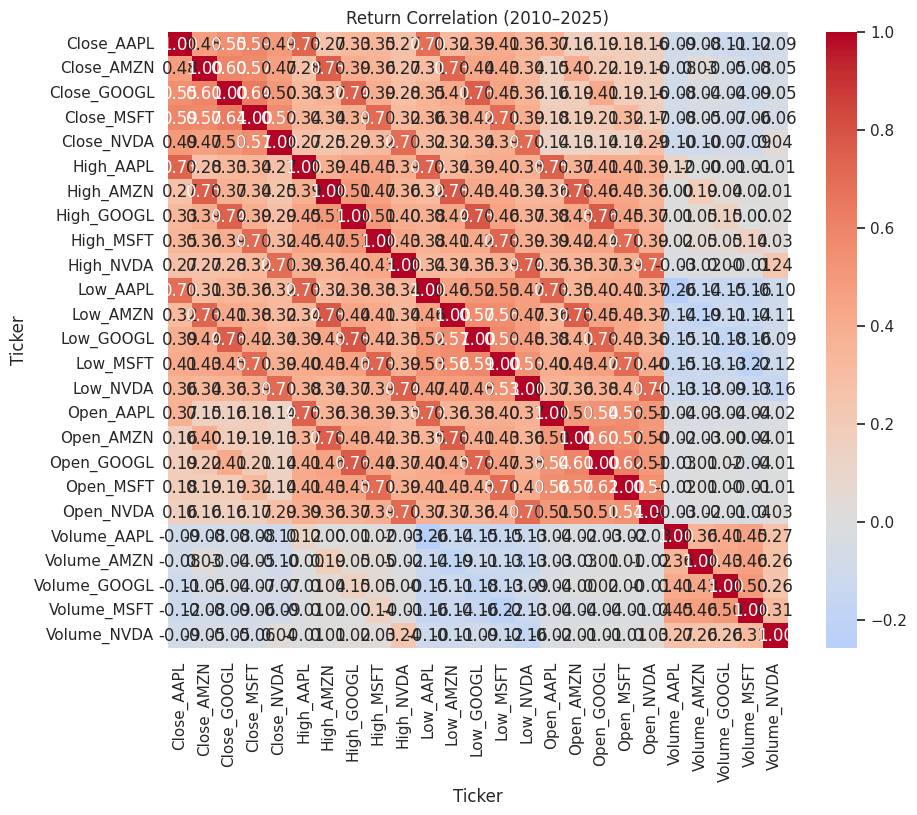

In [23]:
### Step 5: Correlation Analysis
# Pivot to wide format for returns
ret_wide = df_returns.pivot(index='Date', columns='Ticker', values='log_return').reset_index()

# Calculate correlation matrix
corr_mat = ret_wide.drop(columns='Date').corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Return Correlation (2010–2025)')
plt.show()


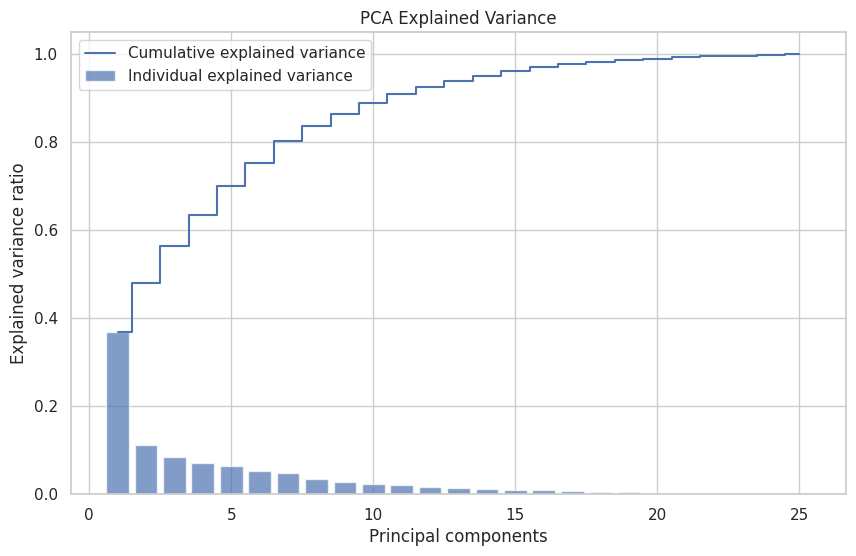

In [24]:
### Step 6: Principal Component Analysis (PCA)
# Prepare data for PCA
X = ret_wide.drop(columns='Date').dropna()

# Standardize and perform PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

# Variance explained
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.7, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('PCA Explained Variance')
plt.show()

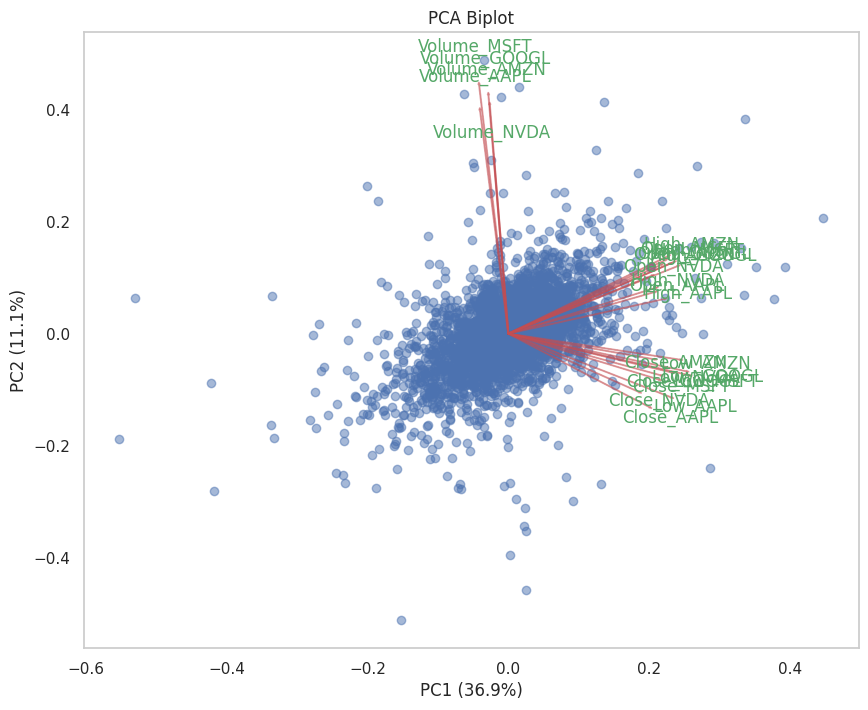

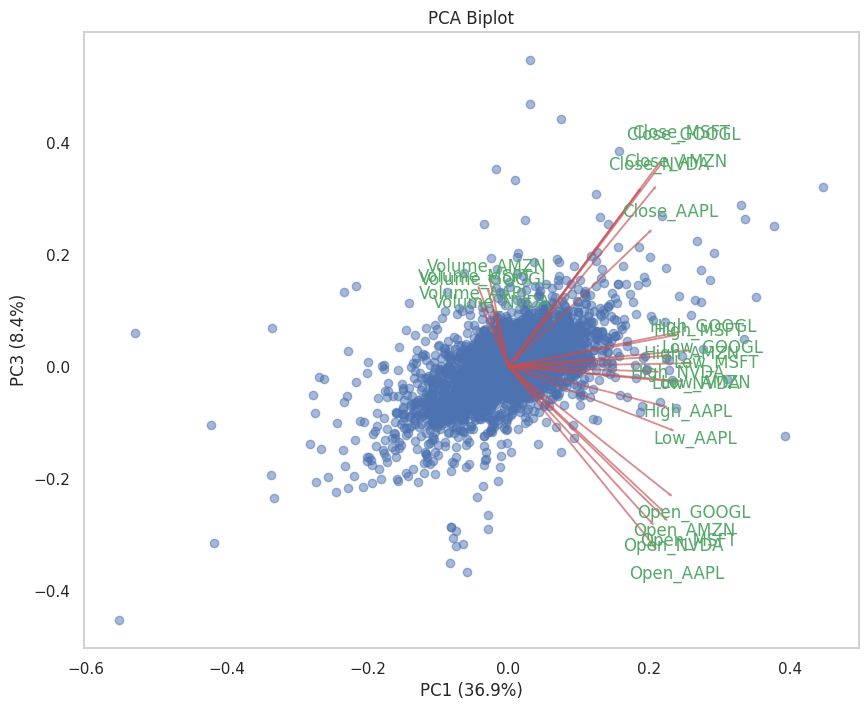

In [25]:
# Biplot function
def biplot(score, coeff, pcax, pcay, labels=None):
    pca1 = pcax-1
    pca2 = pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.figure(figsize=(10, 8))
    plt.scatter(xs * scalex, ys * scaley, alpha=0.5)

    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2], color='r', alpha=0.5)
        plt.text(coeff[i,pca1]*1.15, coeff[i,pca2]*1.15, labels[i],
                 color='g', ha='center', va='center')

    plt.xlabel(f"PC{pcax} ({var_exp[pca1]:.1%})")
    plt.ylabel(f"PC{pcay} ({var_exp[pca2]:.1%})")
    plt.grid()
    plt.title('PCA Biplot')
    plt.show()

# Create biplot
biplot(X_scaled, pca.components_.T, 1, 2, labels=X.columns)
biplot(X_scaled, pca.components_.T, 1, 3, labels=X.columns)


In [38]:
### Step 7: Event Study (COVID Crash)
# Define event windows
est_start = pd.Timestamp('2019-01-01')
est_end = pd.Timestamp('2020-02-19')
evt_start = pd.Timestamp('2020-02-20')
evt_end = pd.Timestamp('2020-03-31')


In [42]:
spy = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in spy.columns.values]

spy.reset_index(inplace=True)
print("SPY columns:", spy.columns)
if 'Close_^GSPC' in spy.columns:
    spy.rename(columns={'Close_^GSPC': 'SPY_Close'}, inplace=True)
elif 'Close' in spy.columns:
    spy.rename(columns={'Close': 'SPY_Close'}, inplace=True)
else:
    raise KeyError("Close price column not found in SPY data")

spy = spy[['Date', 'SPY_Close']]
full_ret = df_returns.merge(spy, on='Date', how='inner')


[*********************100%***********************]  1 of 1 completed

SPY columns: Index(['Date', 'Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC',
       'Volume_^GSPC'],
      dtype='object')


[*********************100%***********************]  1 of 1 completed


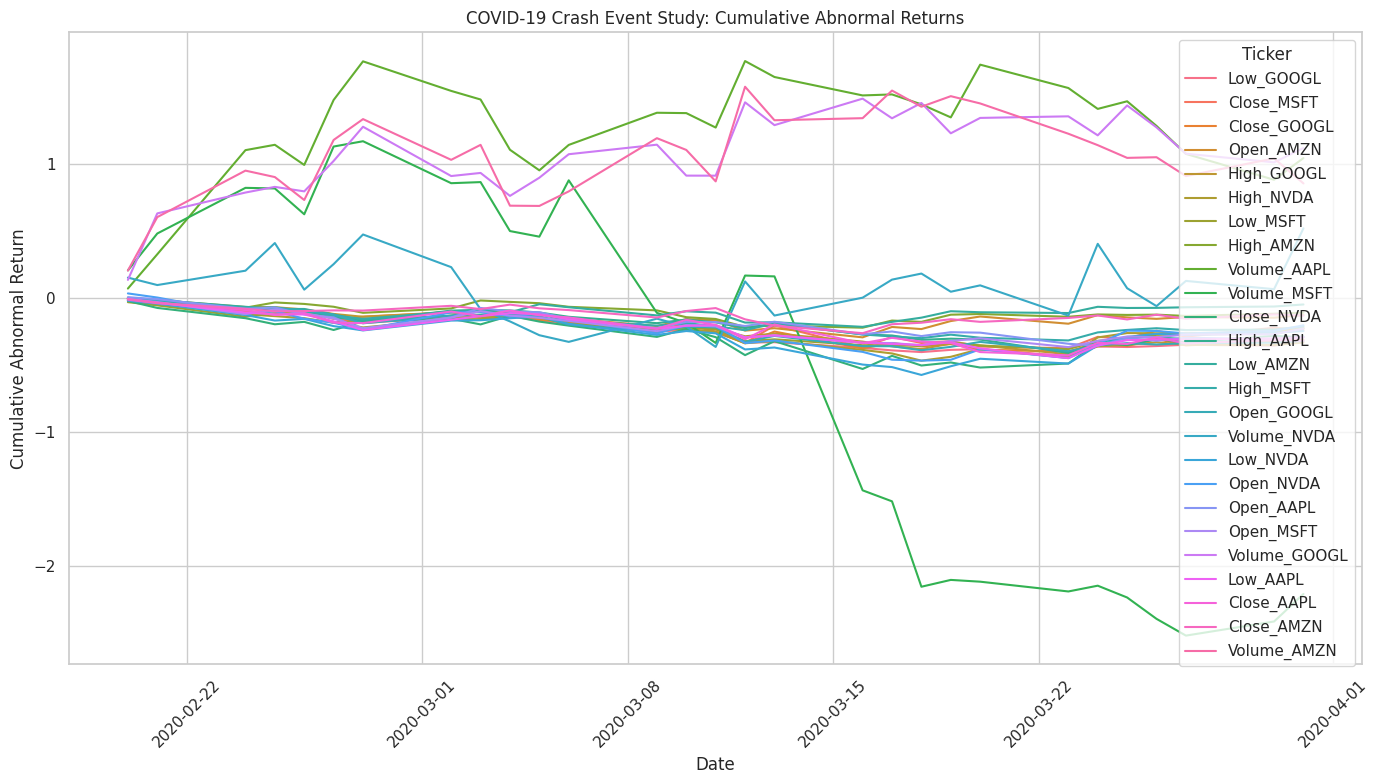

In [48]:
# Step 7: Event Study (COVID Crash) - FIXED

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Define event windows
est_start = pd.Timestamp('2019-01-01')
est_end = pd.Timestamp('2020-02-19')
evt_start = pd.Timestamp('2020-02-20')
evt_end = pd.Timestamp('2020-03-31')

# Download SPY (S&P 500) data
spy = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')

# Handle multi-index columns if present
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in spy.columns.values]

spy.reset_index(inplace=True)

# Rename Close column properly
if 'Close_^GSPC' in spy.columns:
    spy.rename(columns={'Close_^GSPC': 'SPY_Close'}, inplace=True)
elif 'Close' in spy.columns:
    spy.rename(columns={'Close': 'SPY_Close'}, inplace=True)
else:
    raise KeyError("Close price column not found in SPY data")

# Keep only relevant columns
spy = spy[['Date', 'SPY_Close']]

# Merge with df_returns
full_ret = df_returns.merge(spy, on='Date', how='inner')

# Calculate market returns (log returns of SPY)
full_ret = full_ret.sort_values('Date')
full_ret['mkt_ret'] = np.log(full_ret['SPY_Close'] / full_ret['SPY_Close'].shift(1))
full_ret.dropna(subset=['mkt_ret'], inplace=True)

# Estimate alpha and beta for each stock during estimation window
params = []
for ticker in full_ret['Ticker'].unique():
    df_temp = full_ret[
        (full_ret['Date'] >= est_start) &
        (full_ret['Date'] <= est_end) &
        (full_ret['Ticker'] == ticker)
    ]

    if len(df_temp) > 1:
        X = df_temp['mkt_ret'].values.reshape(-1, 1)
        y = df_temp['log_return'].values
        slope, intercept = np.polyfit(X.flatten(), y, 1)
        params.append({'Ticker': ticker, 'alpha': intercept, 'beta': slope})

params_df = pd.DataFrame(params)

# Proceed if parameters are available
if not params_df.empty:
    # Filter for event window
    ar = full_ret[(full_ret['Date'] >= evt_start) & (full_ret['Date'] <= evt_end)]
    ar = ar.merge(params_df, on='Ticker')

    # Calculate abnormal and cumulative abnormal returns
    ar['expected_ret'] = ar['alpha'] + ar['beta'] * ar['mkt_ret']
    ar['abnormal_ret'] = ar['log_return'] - ar['expected_ret']
    ar['CAR'] = ar.groupby('Ticker')['abnormal_ret'].cumsum()

    # Plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=ar, x='Date', y='CAR', hue='Ticker')
    plt.title('COVID-19 Crash Event Study: Cumulative Abnormal Returns')
    plt.ylabel('Cumulative Abnormal Return')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No parameters estimated — check data availability for estimation period.")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

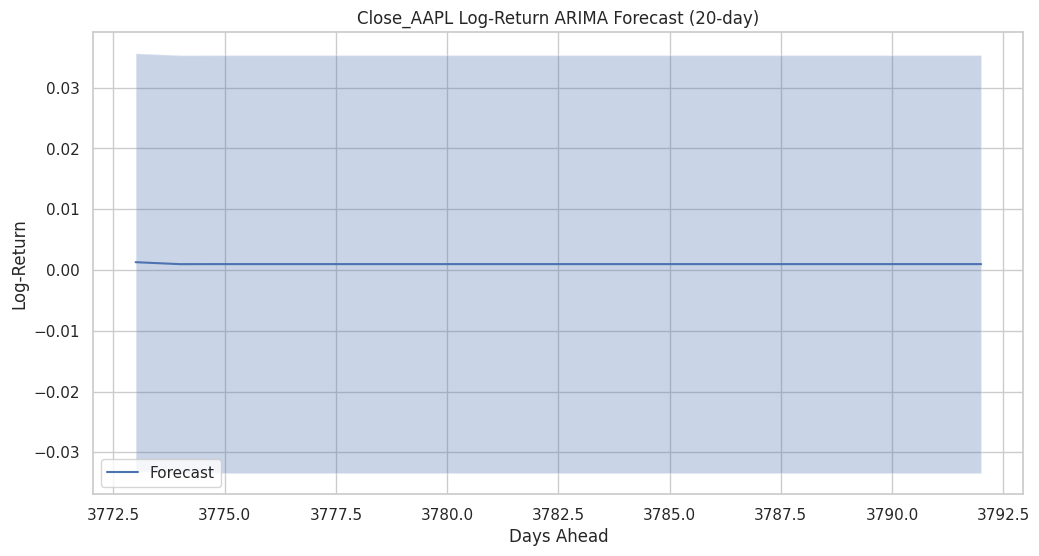

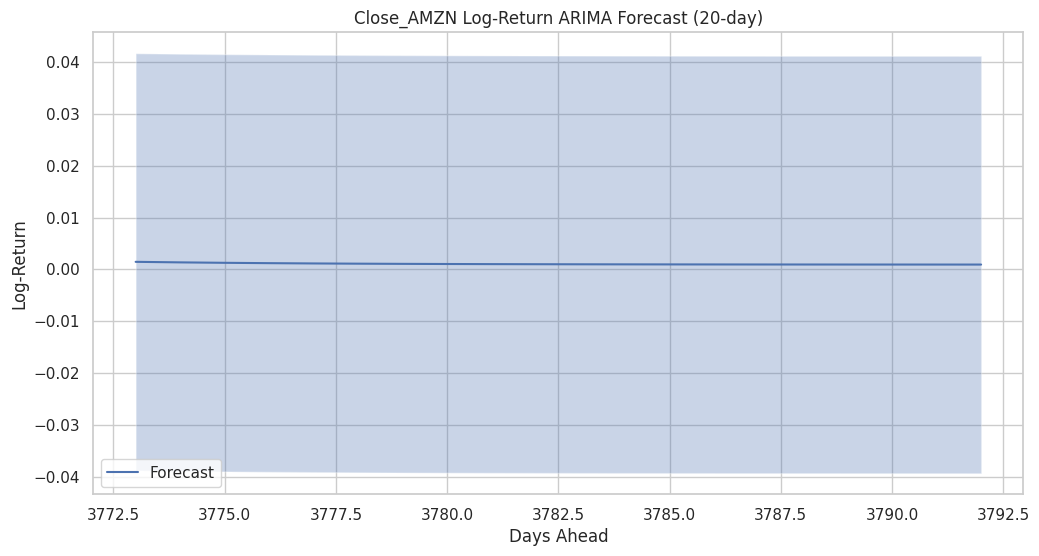

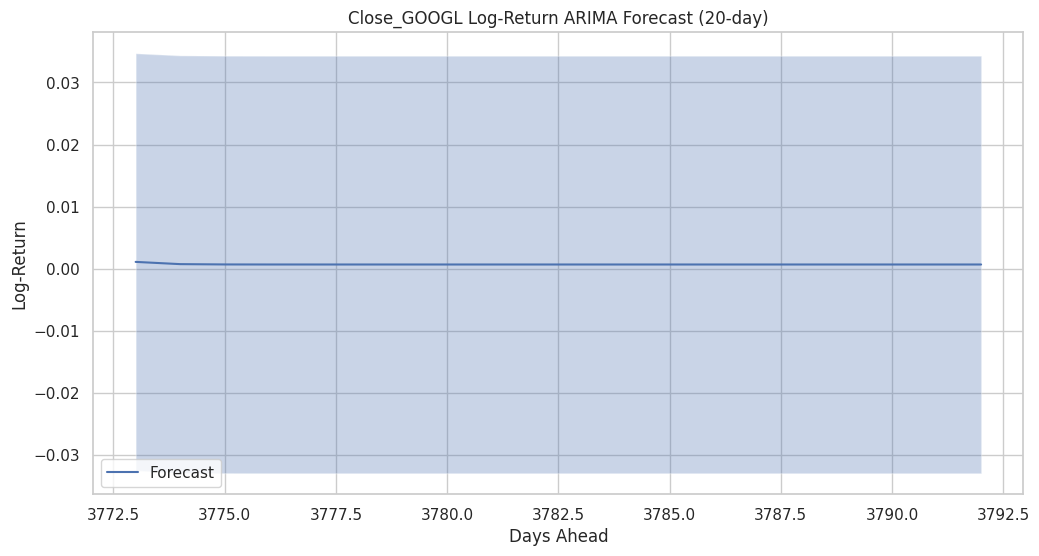

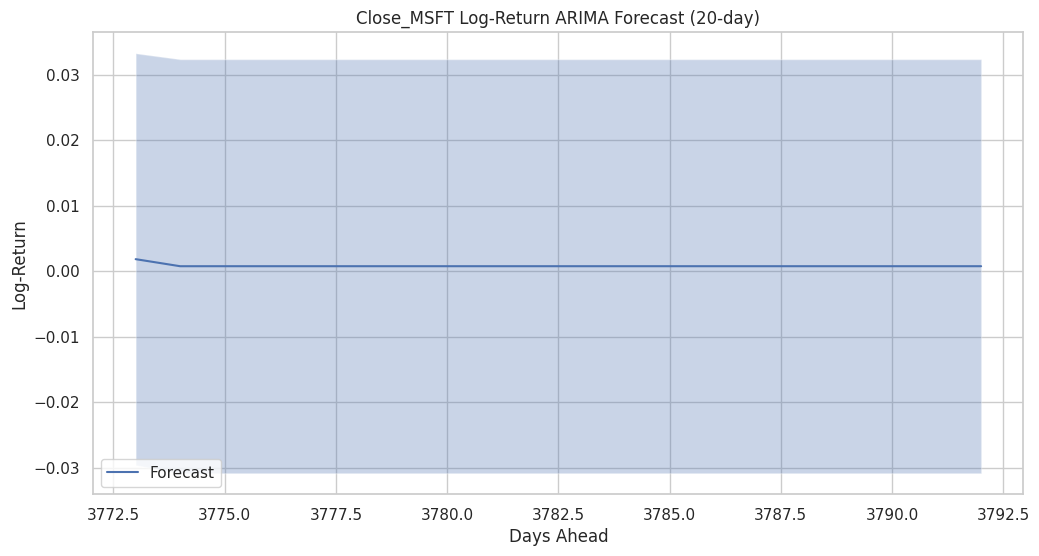

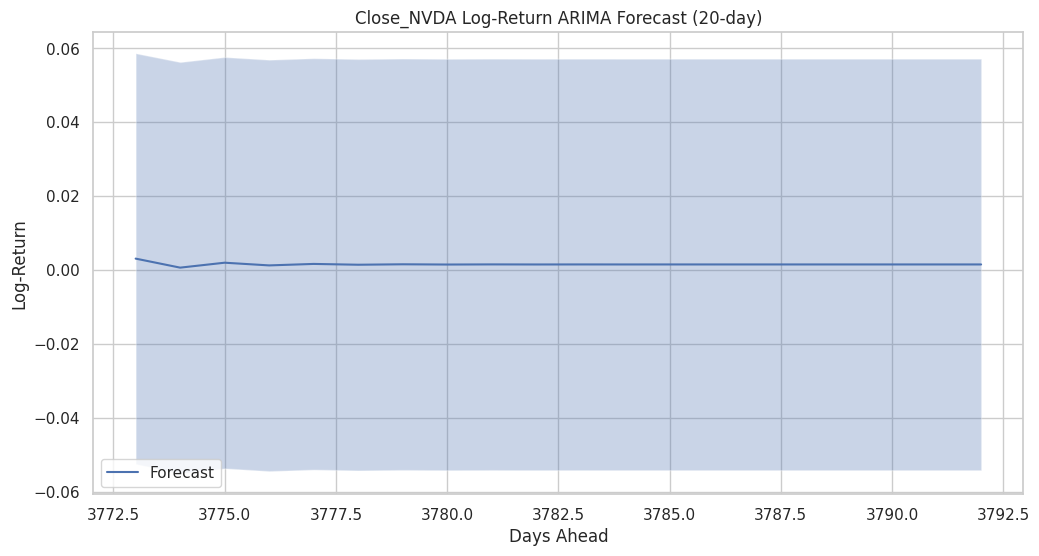

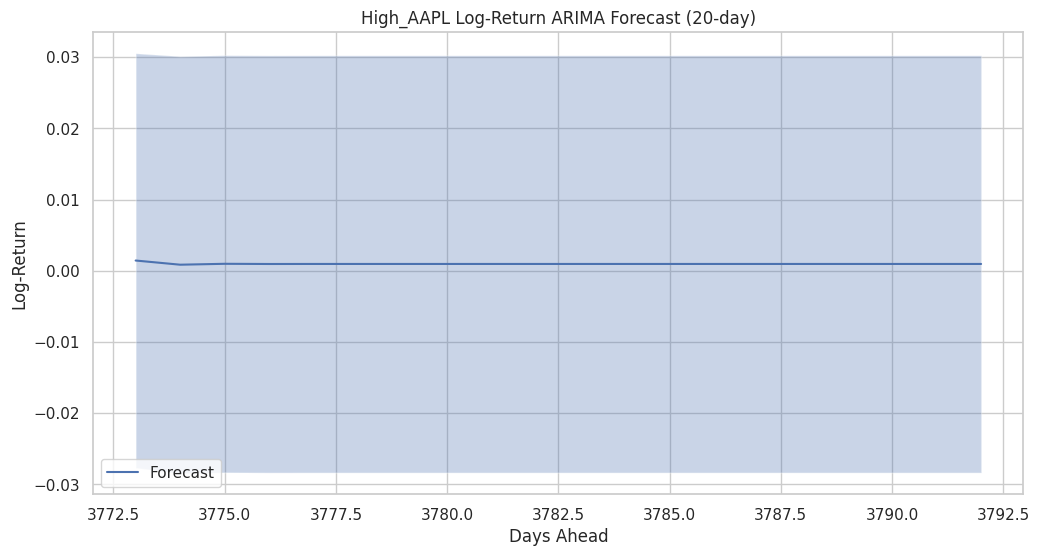

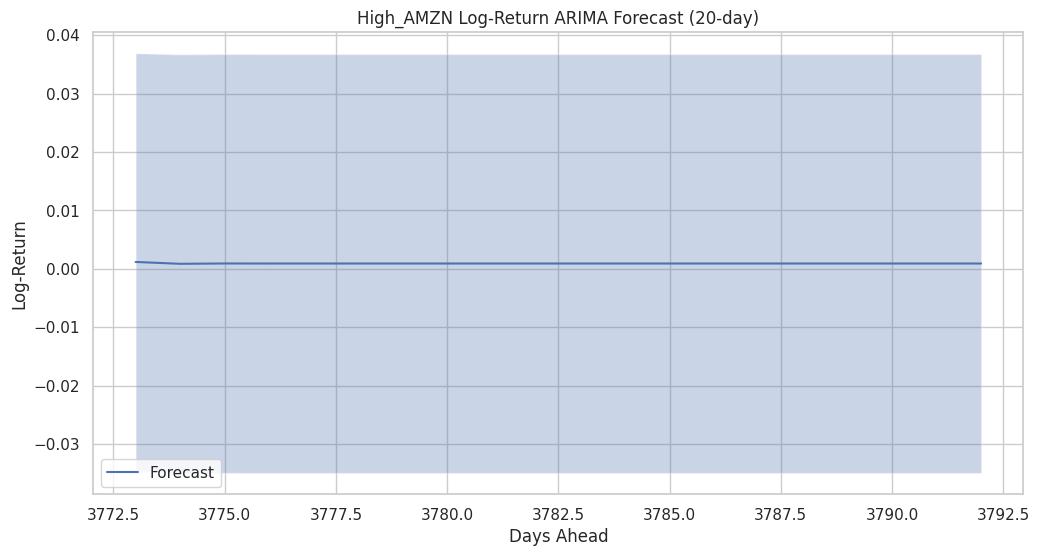

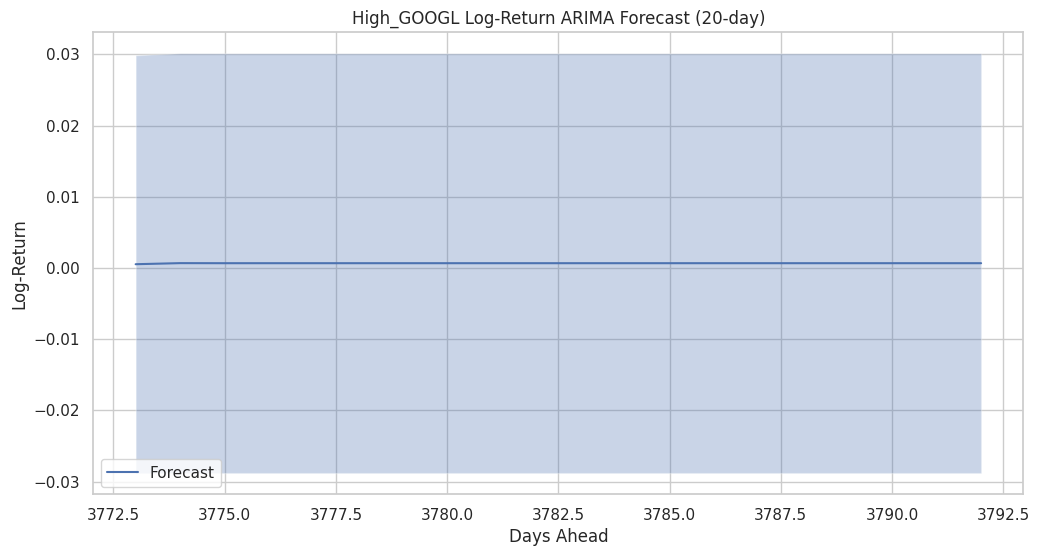

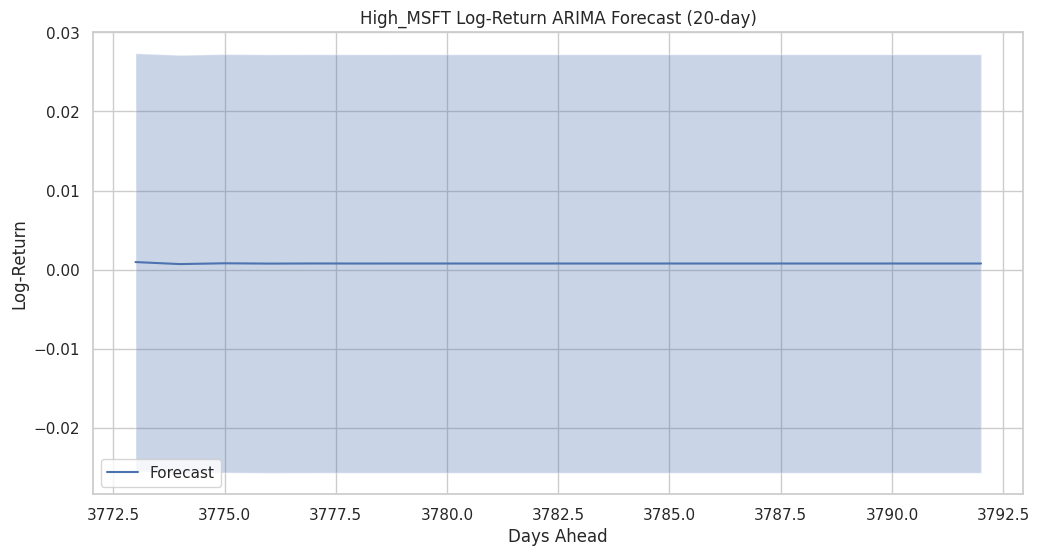

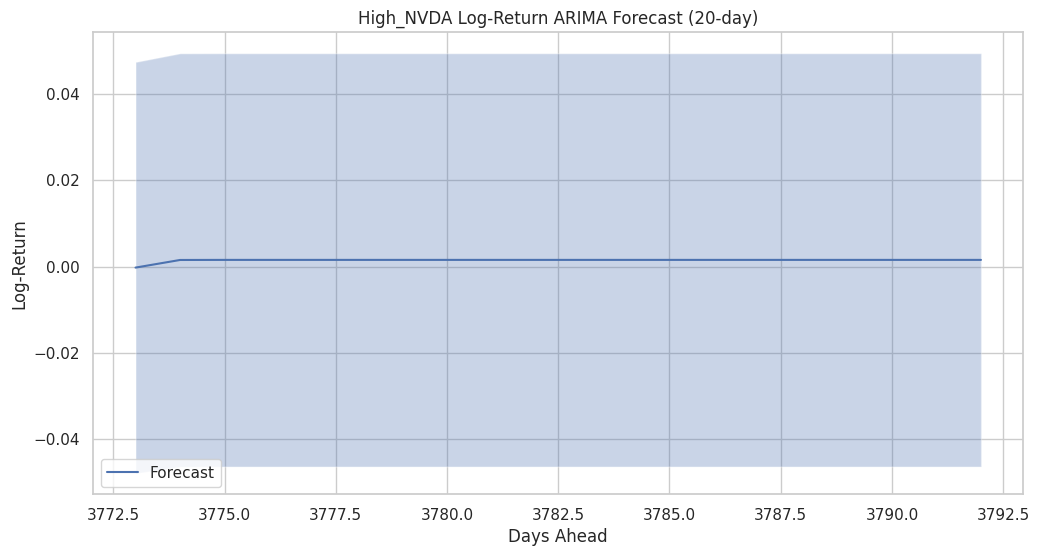

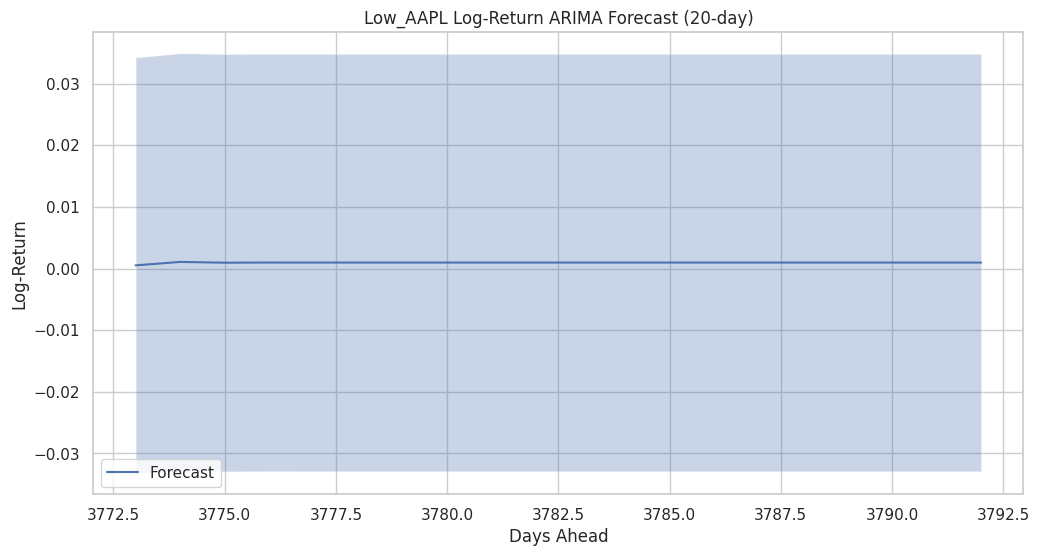

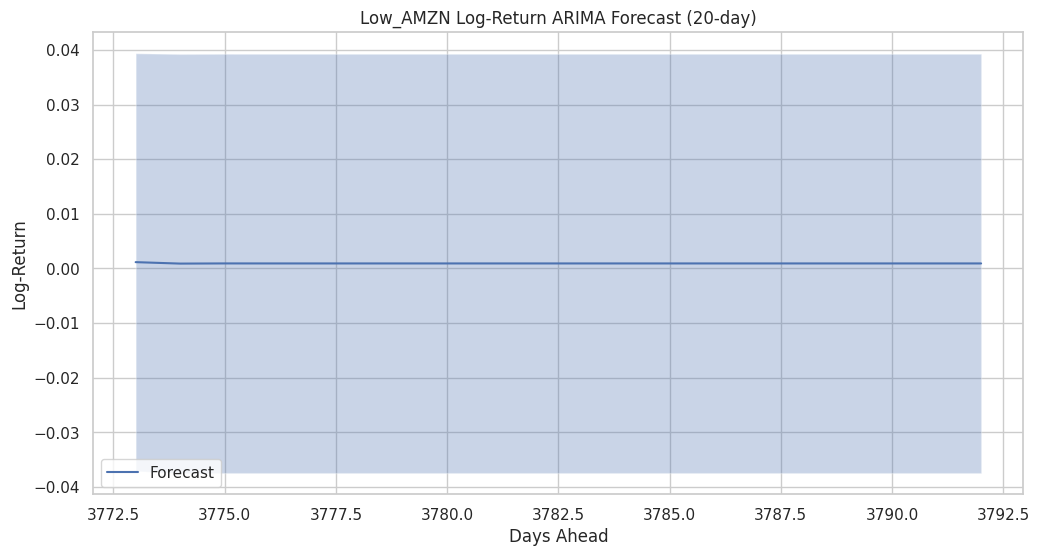

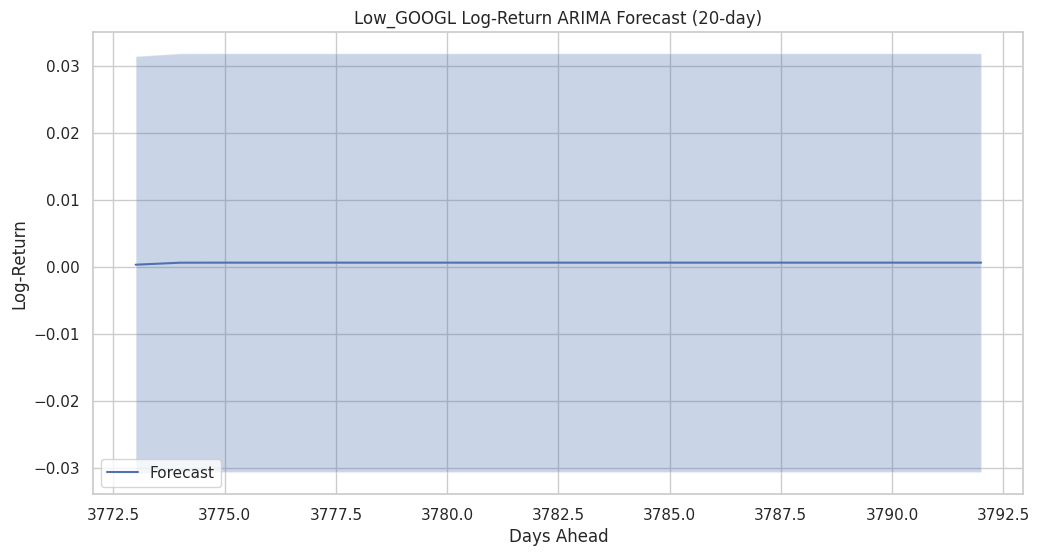

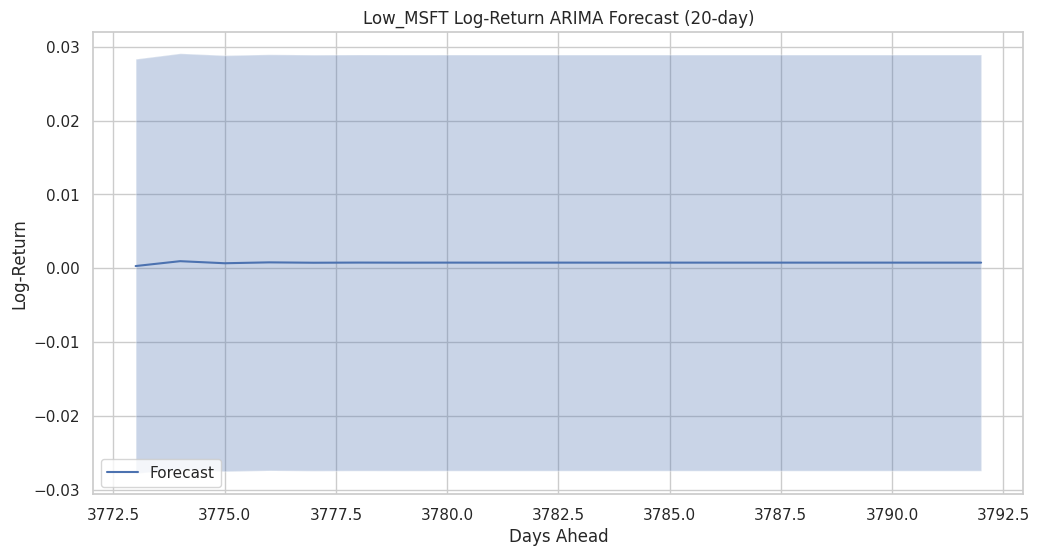

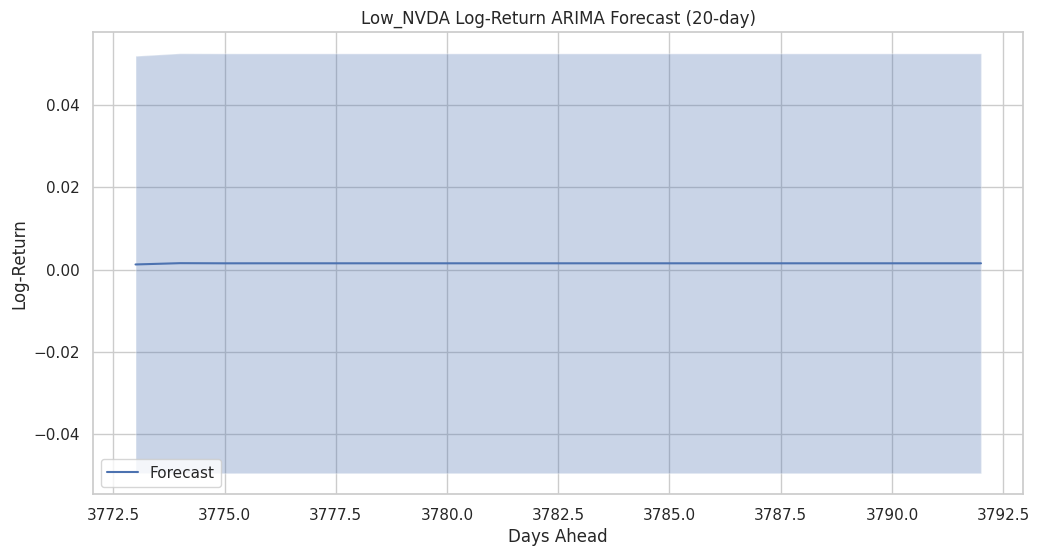

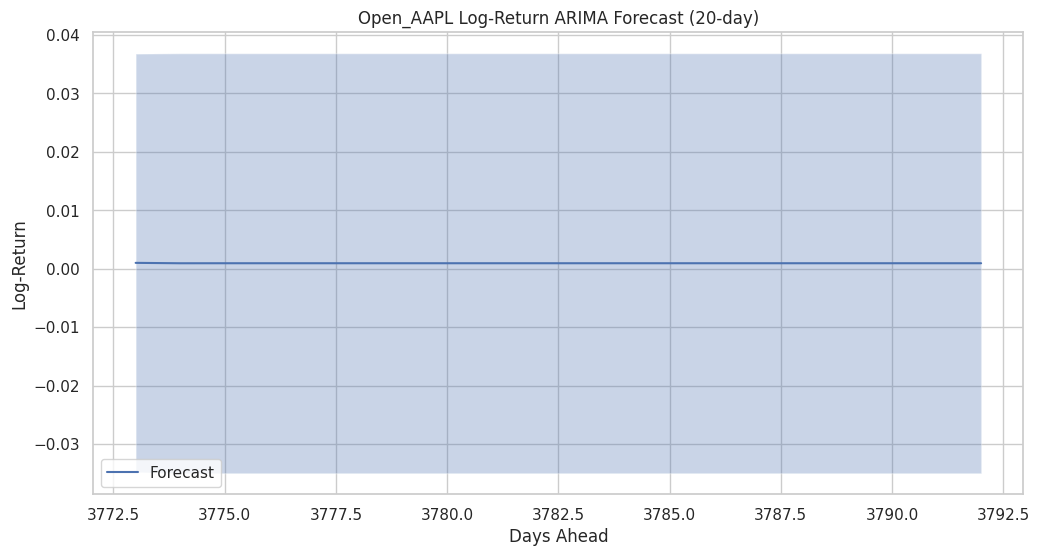

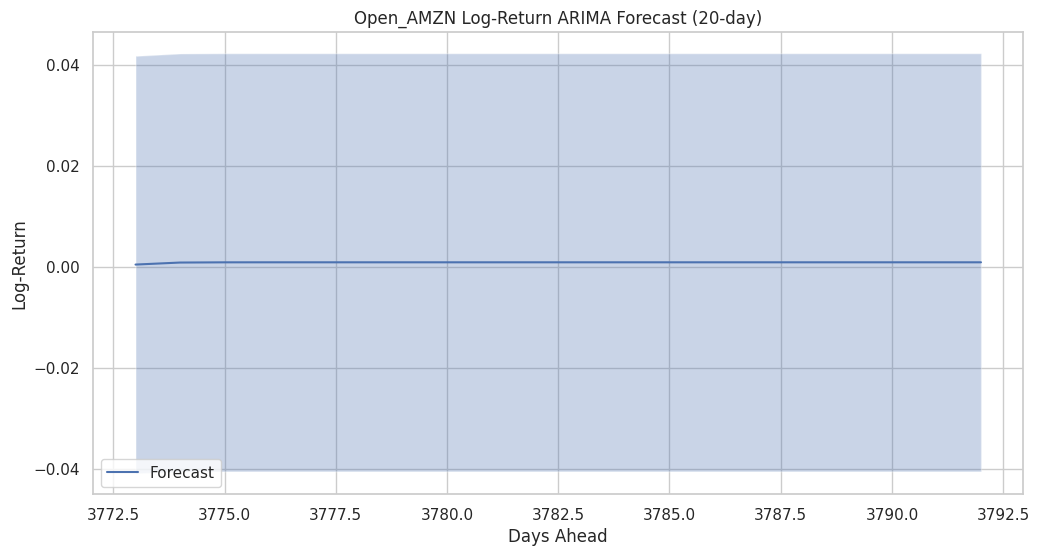

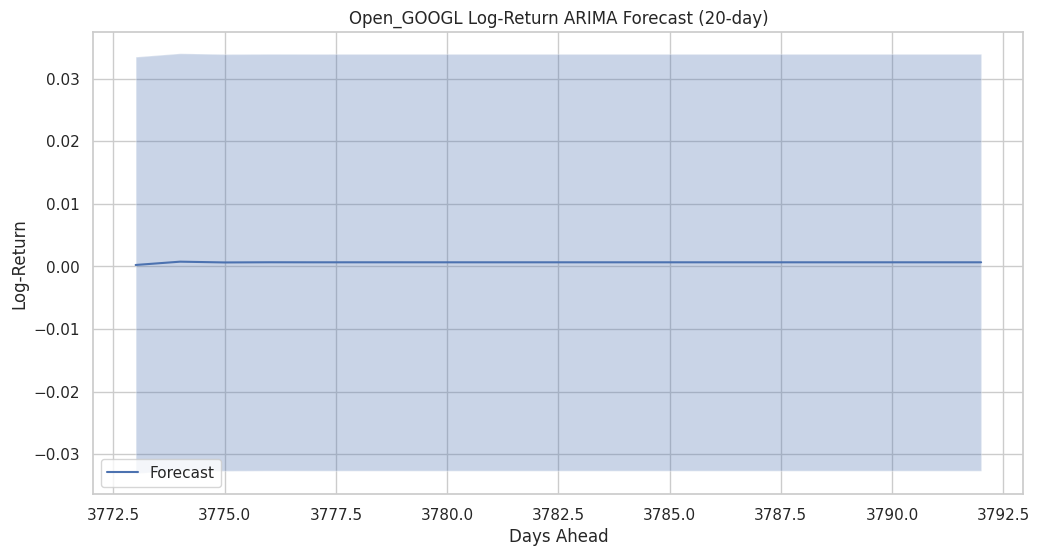

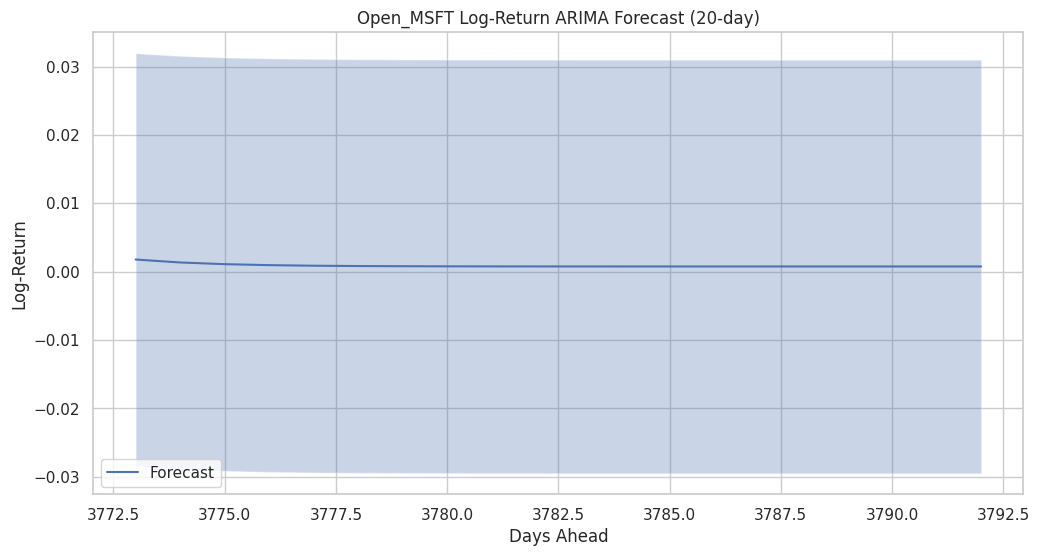

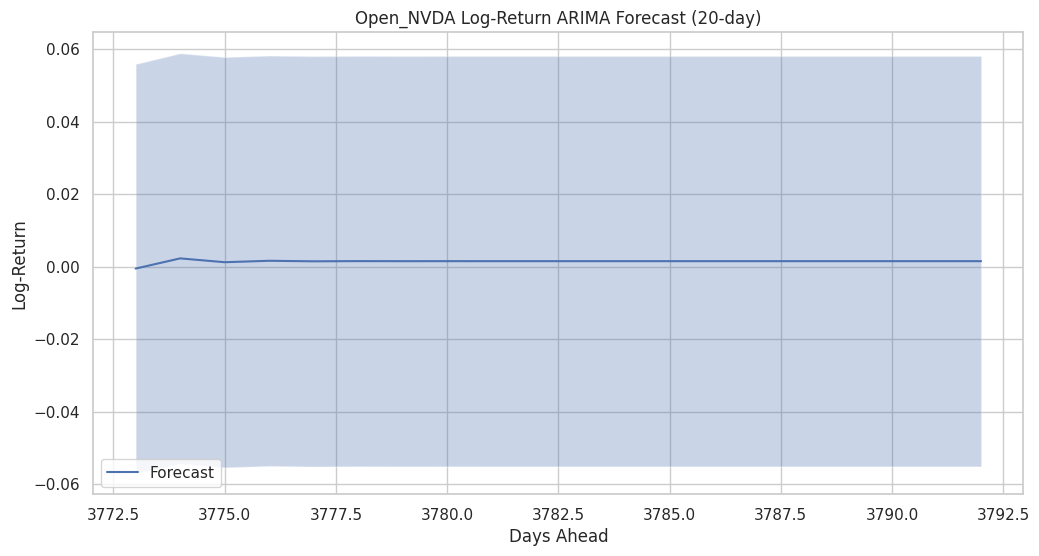

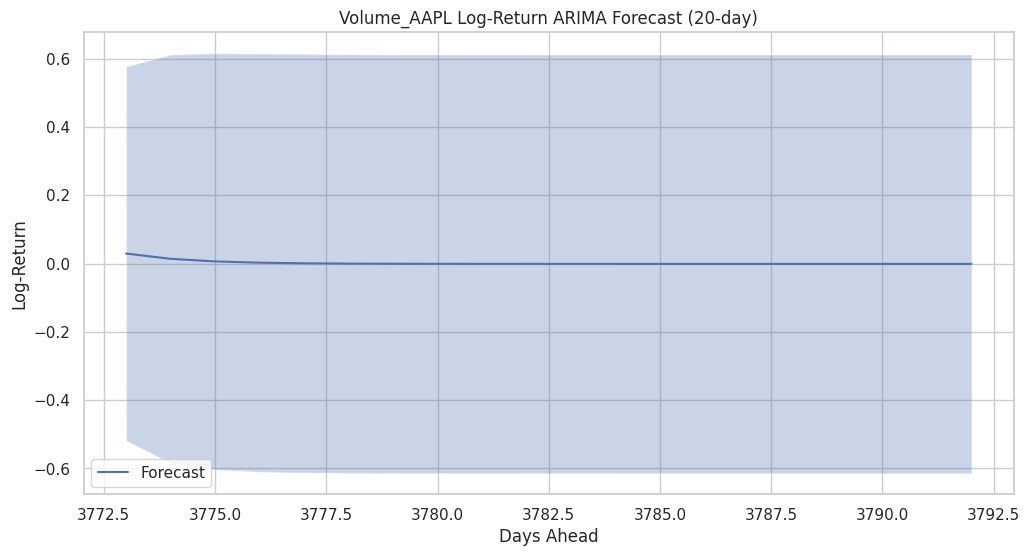

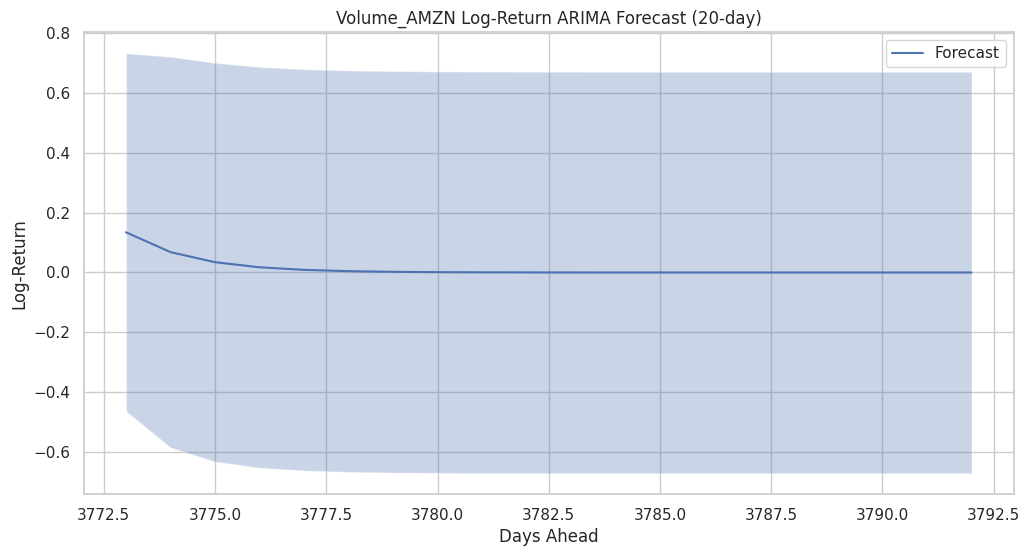

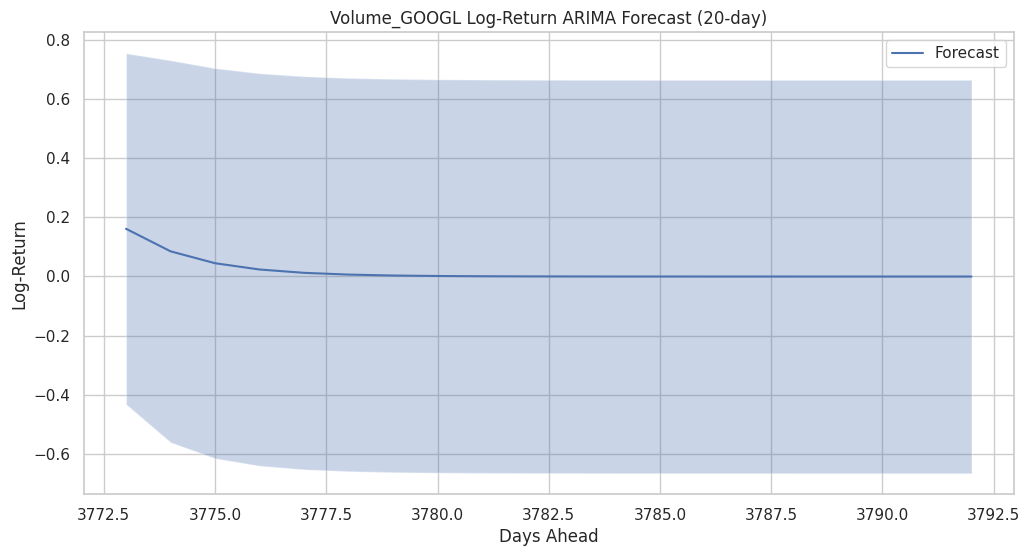

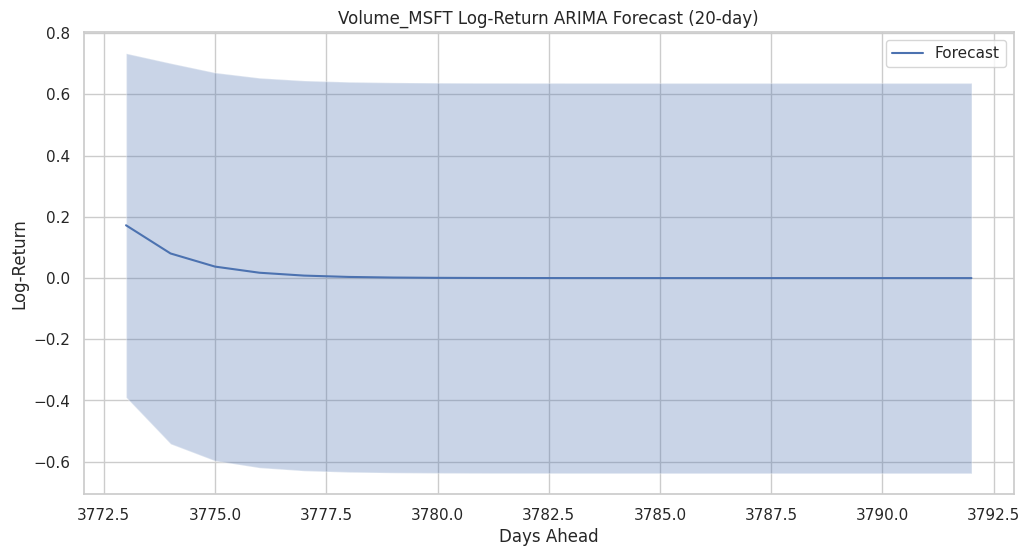

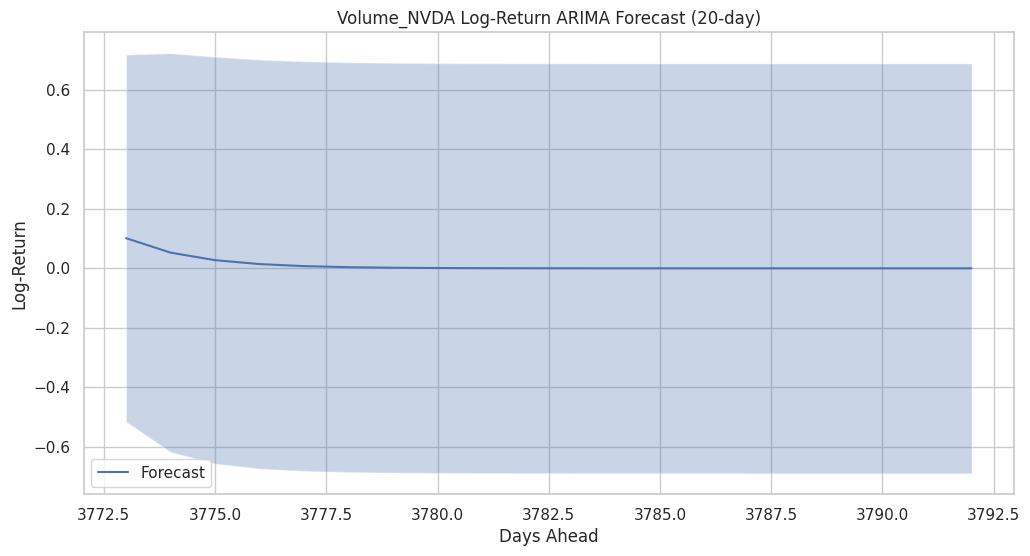

In [49]:
### Step 8: Time Series Forecasting
# ARIMA Forecasting
def arima_forecast(ticker_data):
    model = ARIMA(ticker_data['log_return'].dropna(), order=(1,0,1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=20)
    return {
        'forecast': forecast.predicted_mean,
        'conf_int': forecast.conf_int()
    }

# Apply to each ticker
tickers = df_returns['Ticker'].unique()
arima_results = {}
for ticker in tickers:
    ticker_data = df_returns[df_returns['Ticker'] == ticker]
    arima_results[ticker] = arima_forecast(ticker_data)

# Plot forecasts
for ticker, result in arima_results.items():
    plt.figure()
    plt.plot(result['forecast'], label='Forecast')
    plt.fill_between(result['conf_int'].index,
                    result['conf_int'].iloc[:,0],
                    result['conf_int'].iloc[:,1],
                    alpha=0.3)
    plt.title(f'{ticker} Log-Return ARIMA Forecast (20-day)')
    plt.xlabel('Days Ahead')
    plt.ylabel('Log-Return')
    plt.legend()
    plt.show()

In [50]:
### Step 9: Prophet Forecasting
prophet_forecasts = {}
for ticker in tickers:
    df_prophet = df_long[df_long['Ticker'] == ticker][['Date', 'Close']]
    df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

    model = Prophet(daily_seasonality=False)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)

    prophet_forecasts[ticker] = forecast

    # Plot
    fig = model.plot(forecast)
    plt.title(f'{ticker} Prophet Forecast')
    plt.show()

    # Components
    fig = model.plot_components(forecast)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


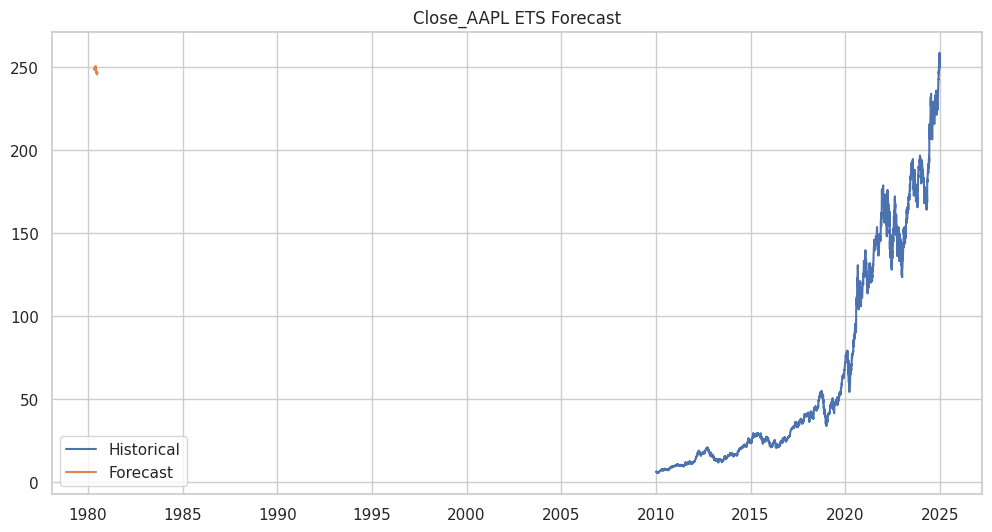

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


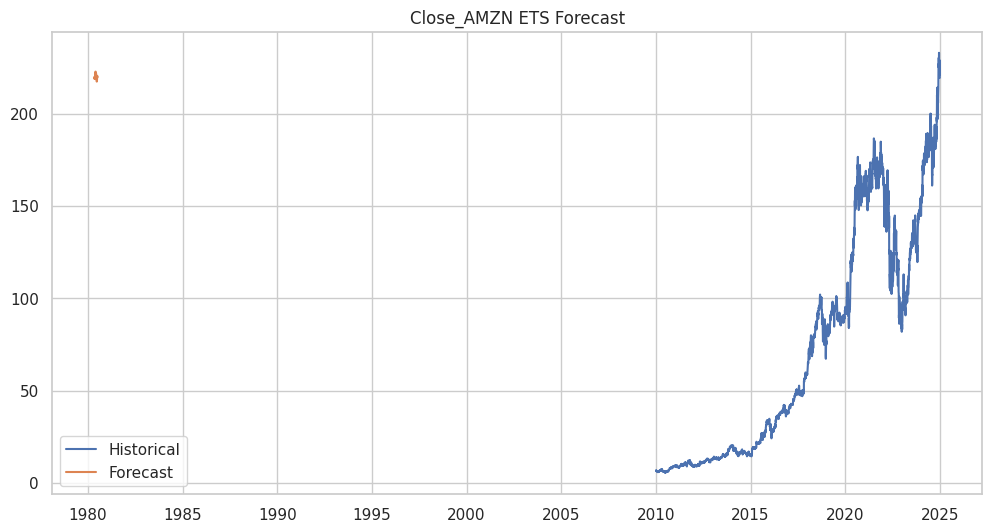

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


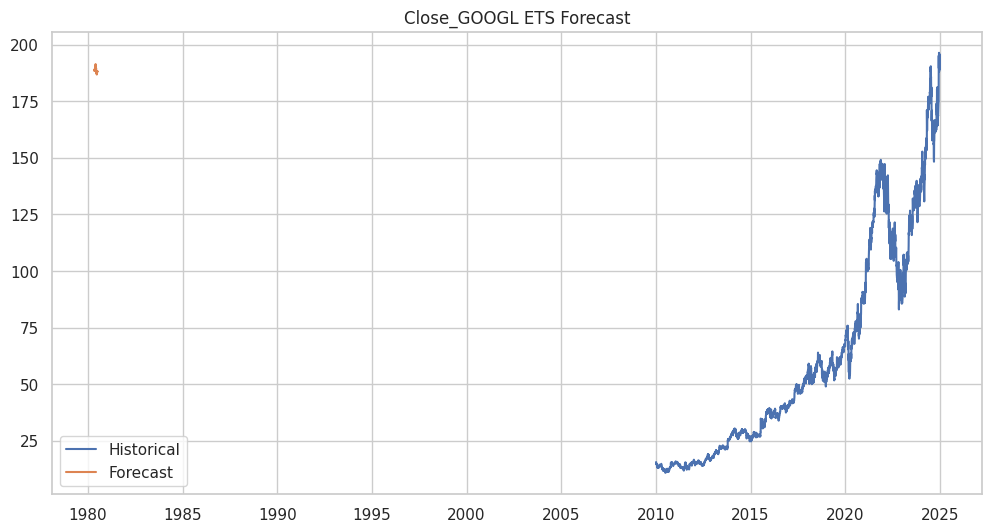

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


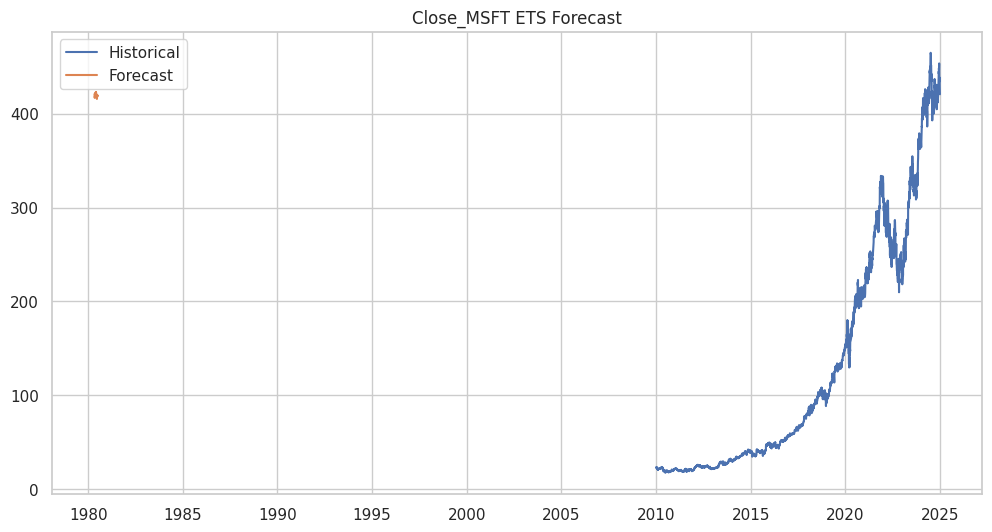

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


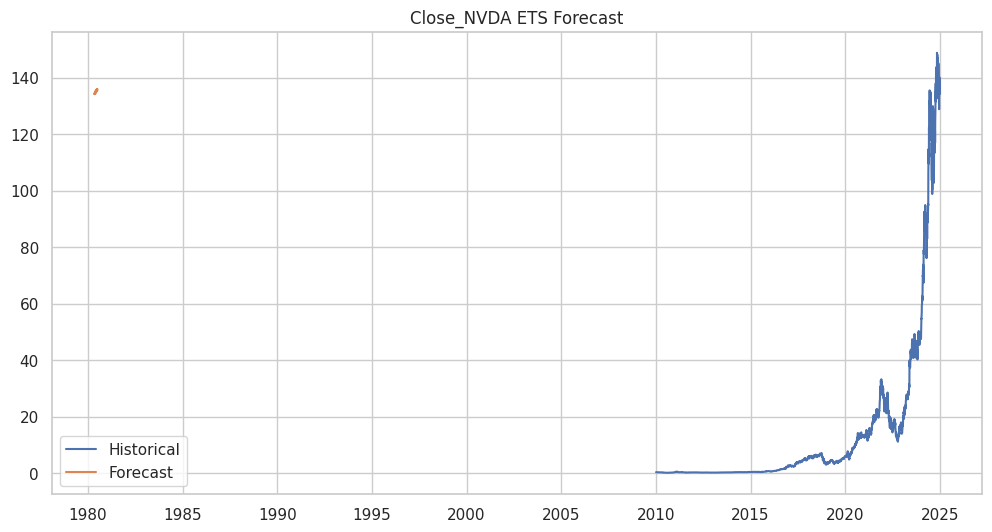

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


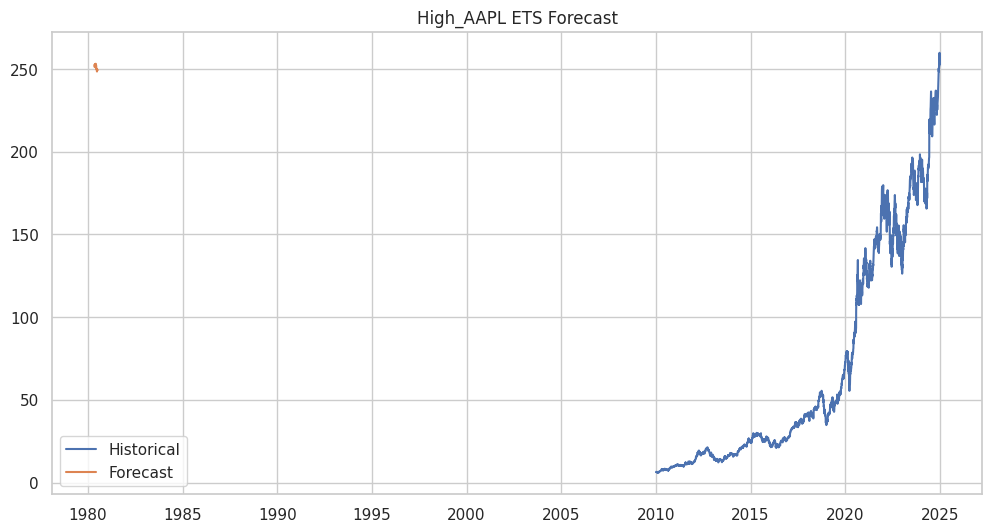

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


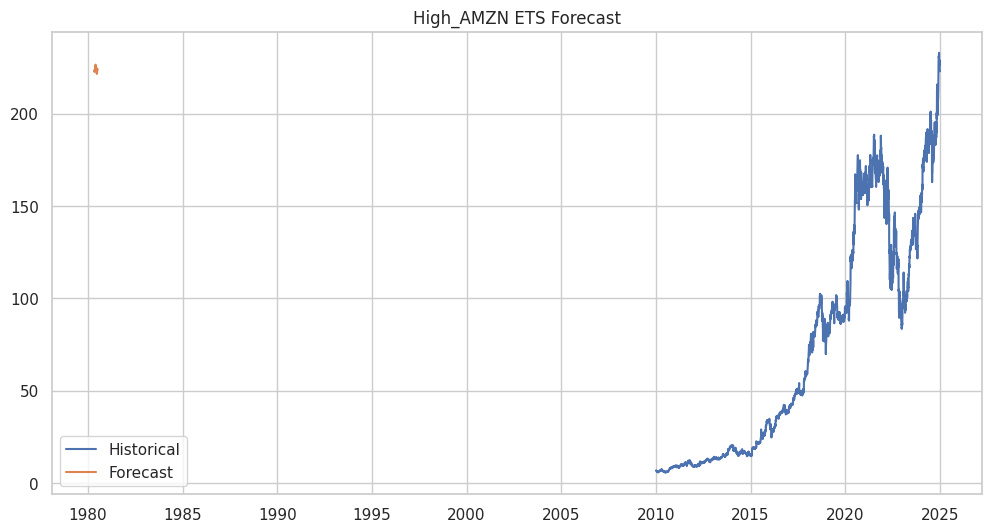

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


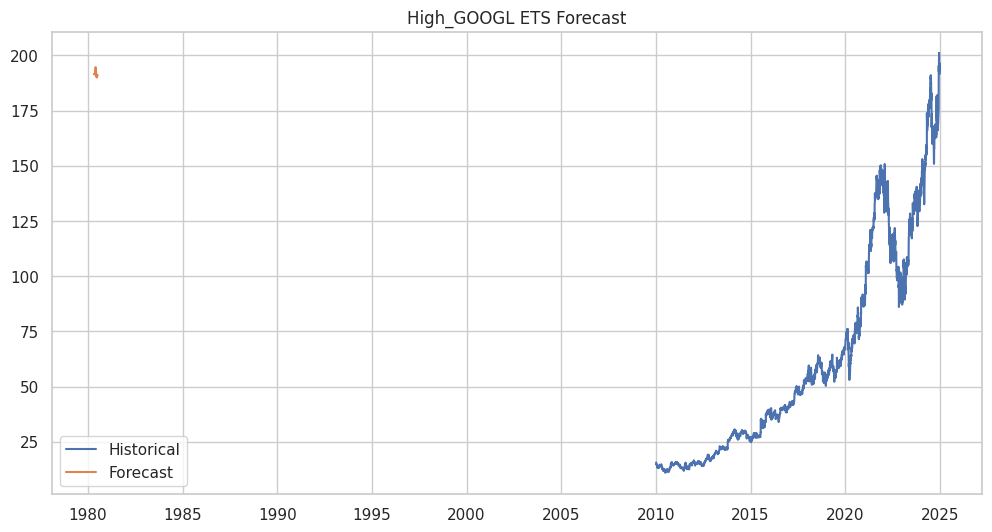

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


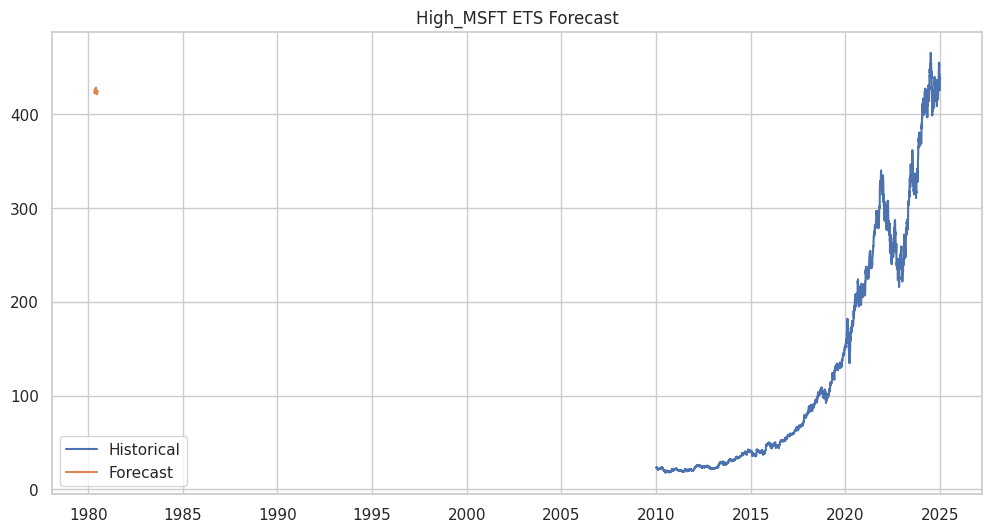

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


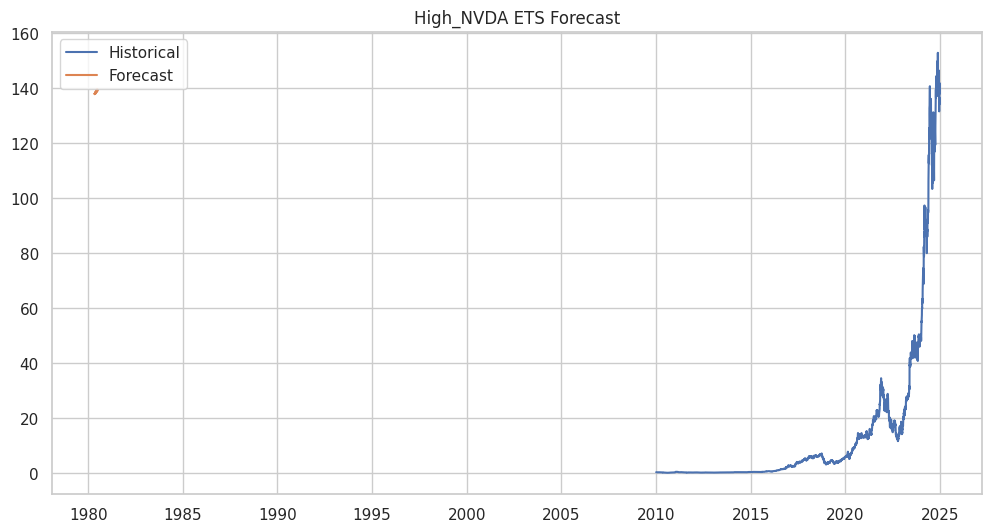

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


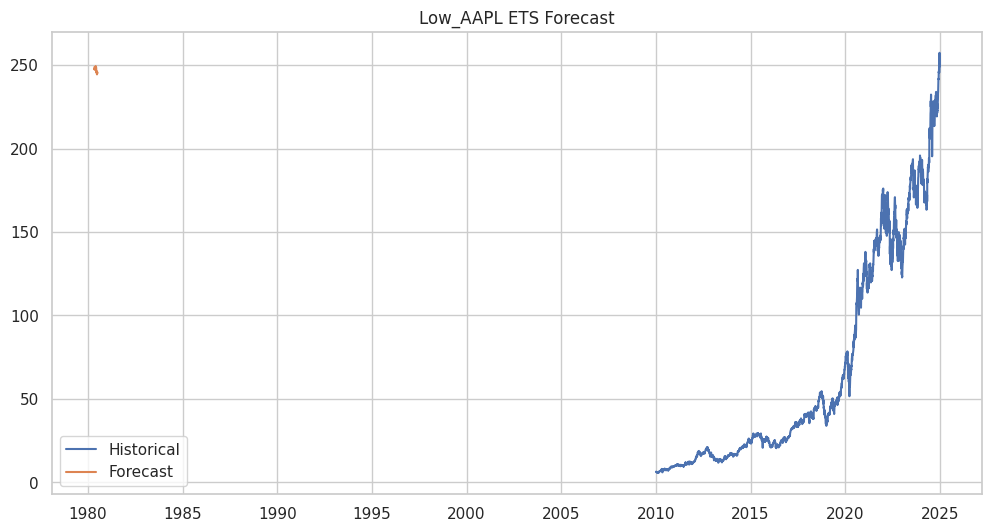

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


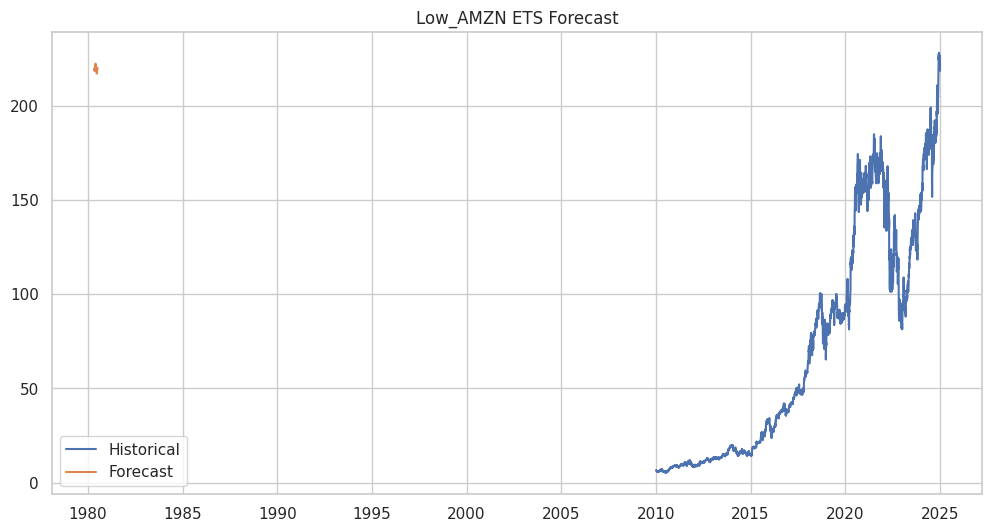

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


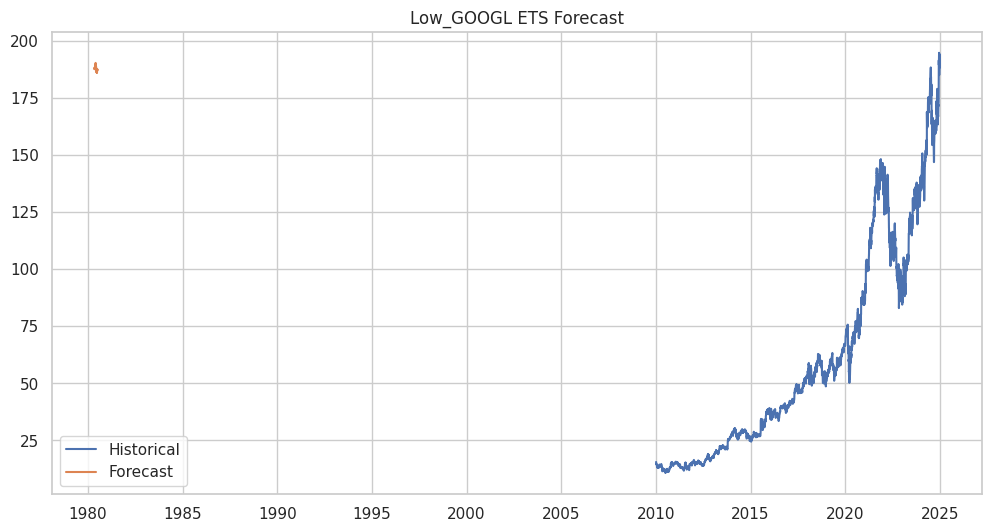

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


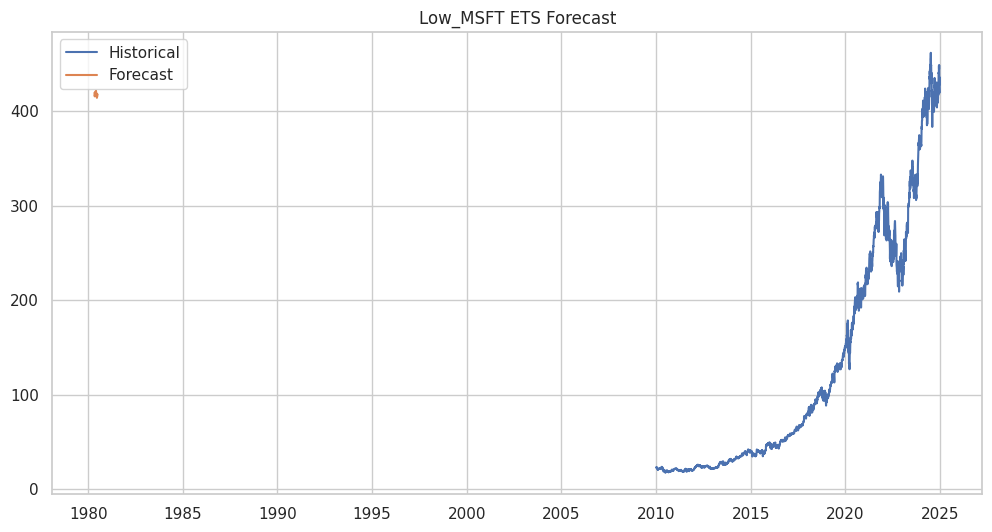

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


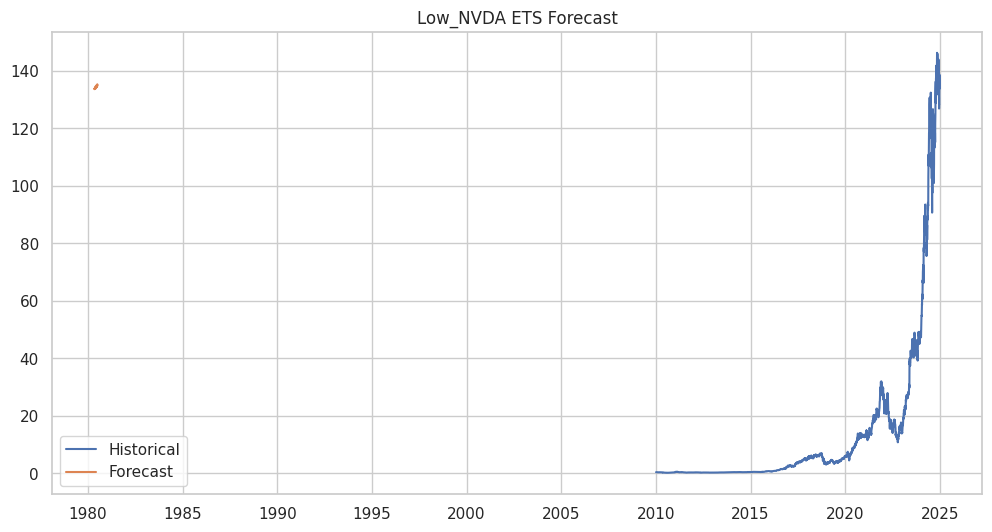

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


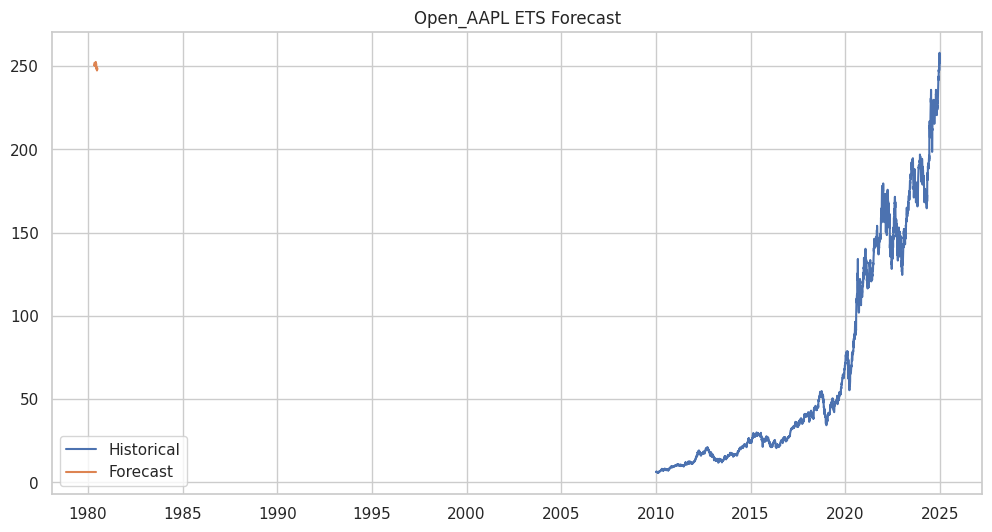

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


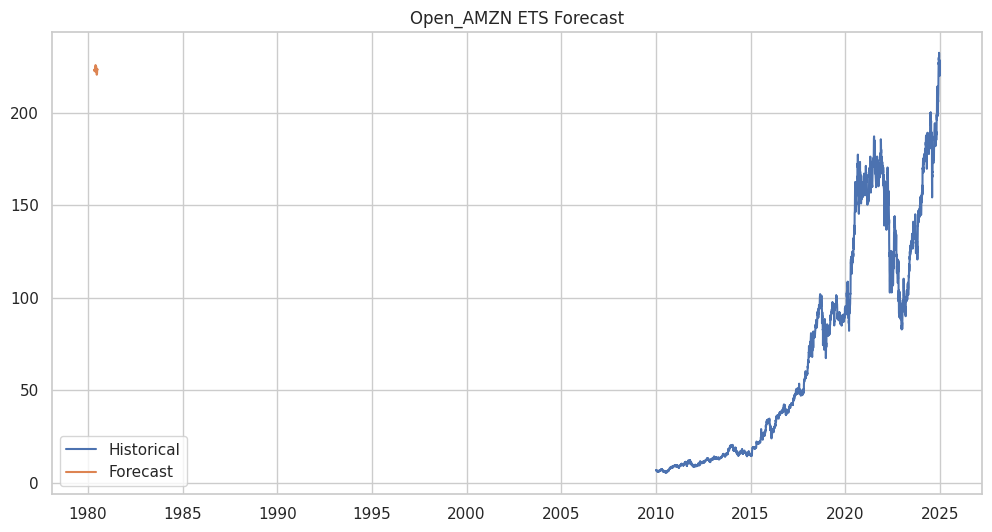

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


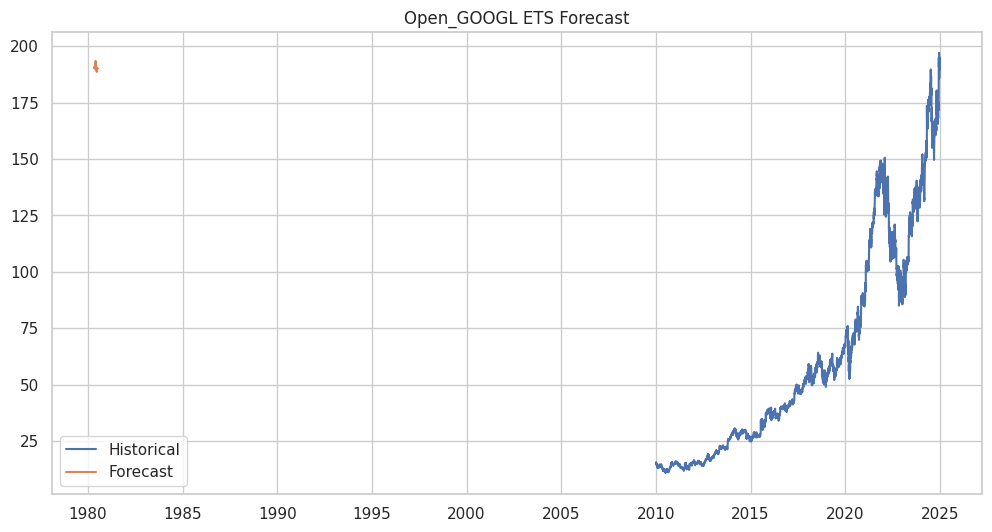

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


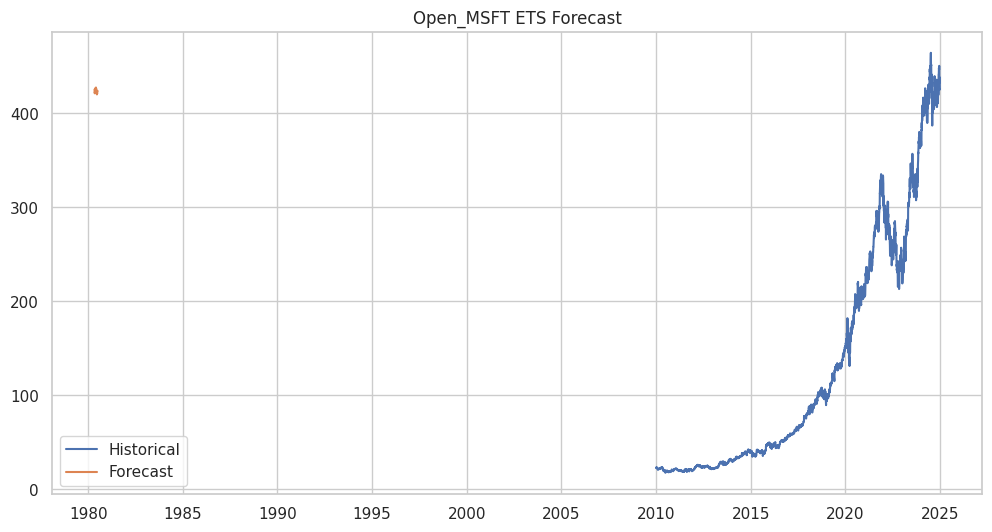

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


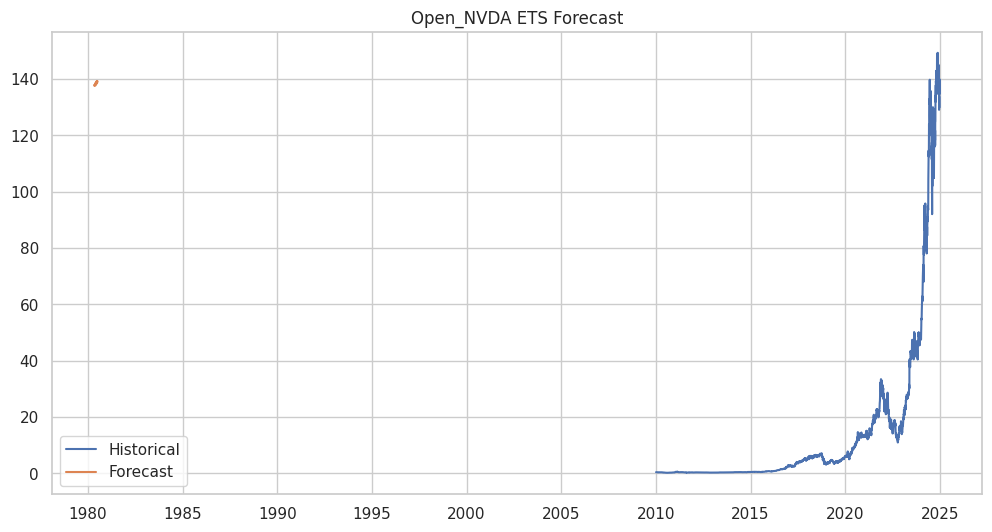

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


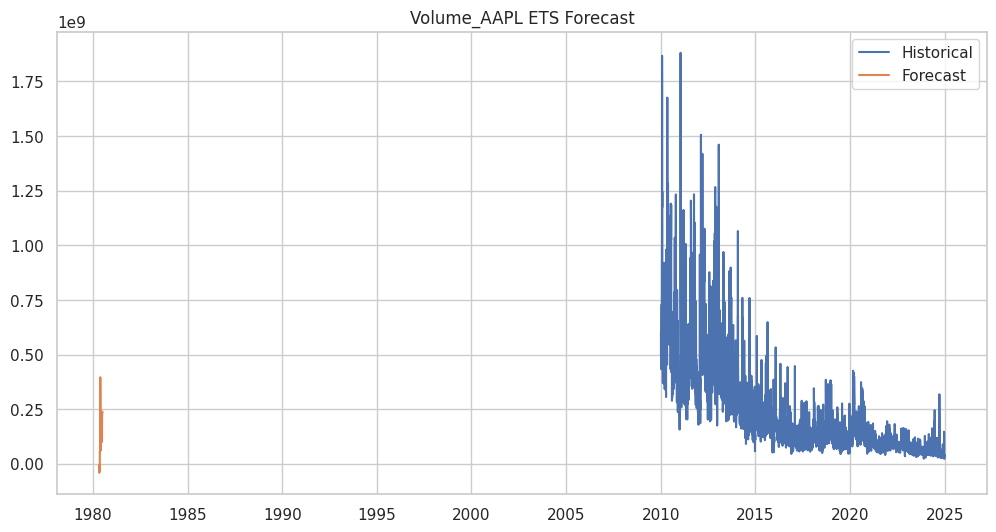

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


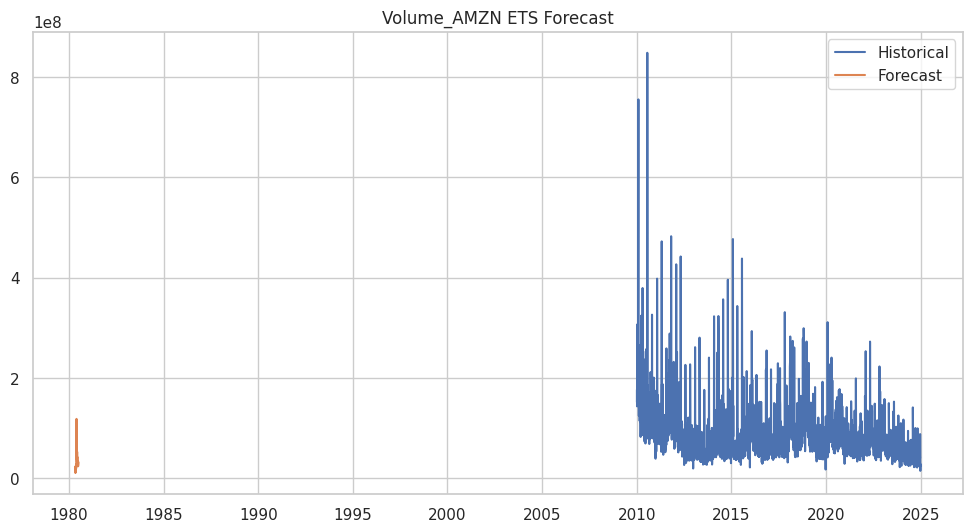

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


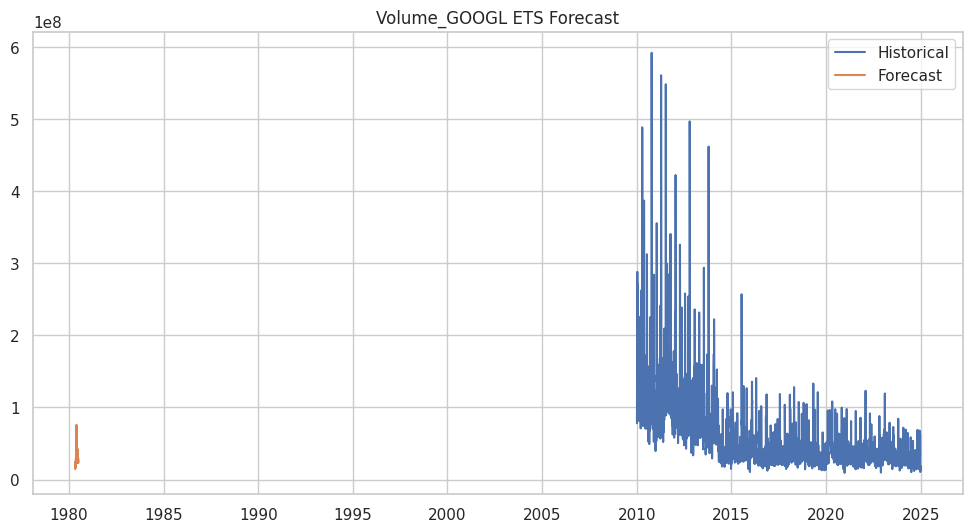

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


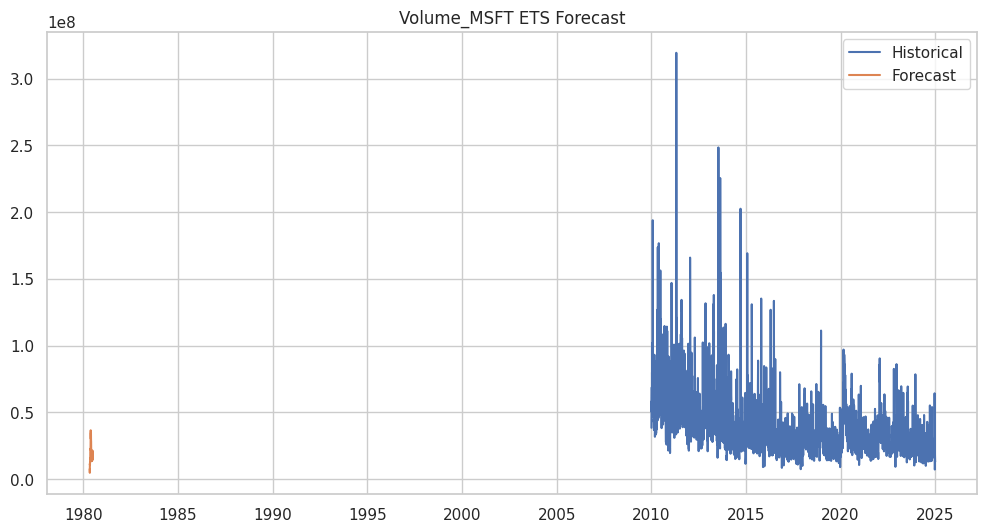

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


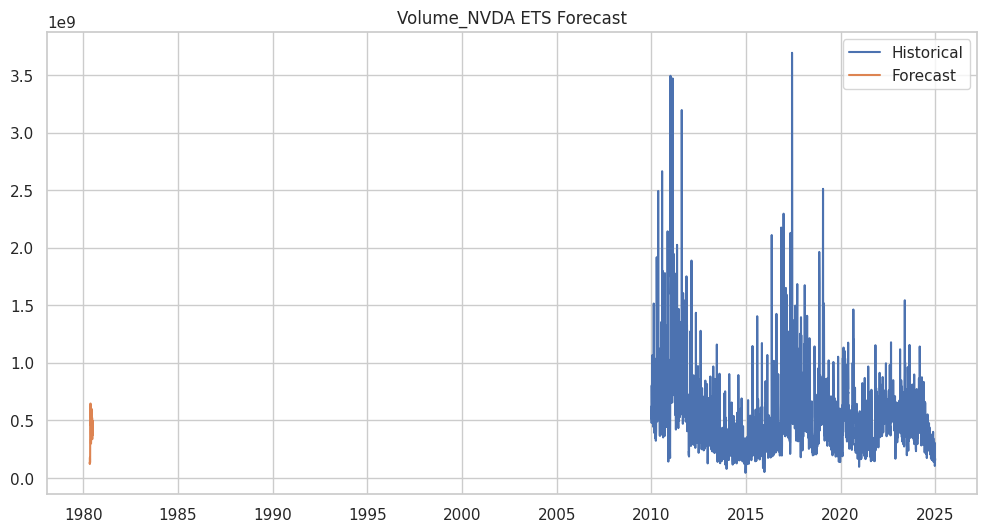

In [51]:
### Step 10: ETS Forecasting
ets_forecasts = {}
for ticker in tickers:
    ticker_data = df_long[df_long['Ticker'] == ticker]
    ts_data = ticker_data.set_index('Date')['Close']

    model = ExponentialSmoothing(ts_data, seasonal='add', seasonal_periods=252)
    model_fit = model.fit()
    forecast = model_fit.forecast(60)

    ets_forecasts[ticker] = forecast

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data.index, ts_data, label='Historical')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.title(f'{ticker} ETS Forecast')
    plt.legend()
    plt.show()


          Ticker  Prophet_MAPE  ETS_MAPE  Prophet_RMSE      ETS_RMSE
0     Close_AAPL      0.085007  0.065772  2.287431e+01  1.739298e+01
1     Close_AMZN      0.150172  0.091865  3.508936e+01  2.122299e+01
2    Close_GOOGL      0.078737  0.093137  1.789494e+01  1.777368e+01
3     Close_MSFT      0.023578  0.024945  1.175421e+01  1.419473e+01
4     Close_NVDA      0.171531  0.036115  2.466824e+01  6.343804e+00
5      High_AAPL      0.085340  0.068796  2.304959e+01  1.827752e+01
6      High_AMZN      0.149427  0.096759  3.531555e+01  2.266585e+01
7     High_GOOGL      0.079382  0.097223  1.835986e+01  1.872924e+01
8      High_MSFT      0.023643  0.024868  1.159908e+01  1.378945e+01
9      High_NVDA      0.169575  0.029061  2.469489e+01  5.429435e+00
10      Low_AAPL      0.084220  0.067949  2.243103e+01  1.794025e+01
11      Low_AMZN      0.147899  0.097476  3.421764e+01  2.238383e+01
12     Low_GOOGL      0.077636  0.096479  1.737574e+01  1.830586e+01
13      Low_MSFT      0.024156  0.

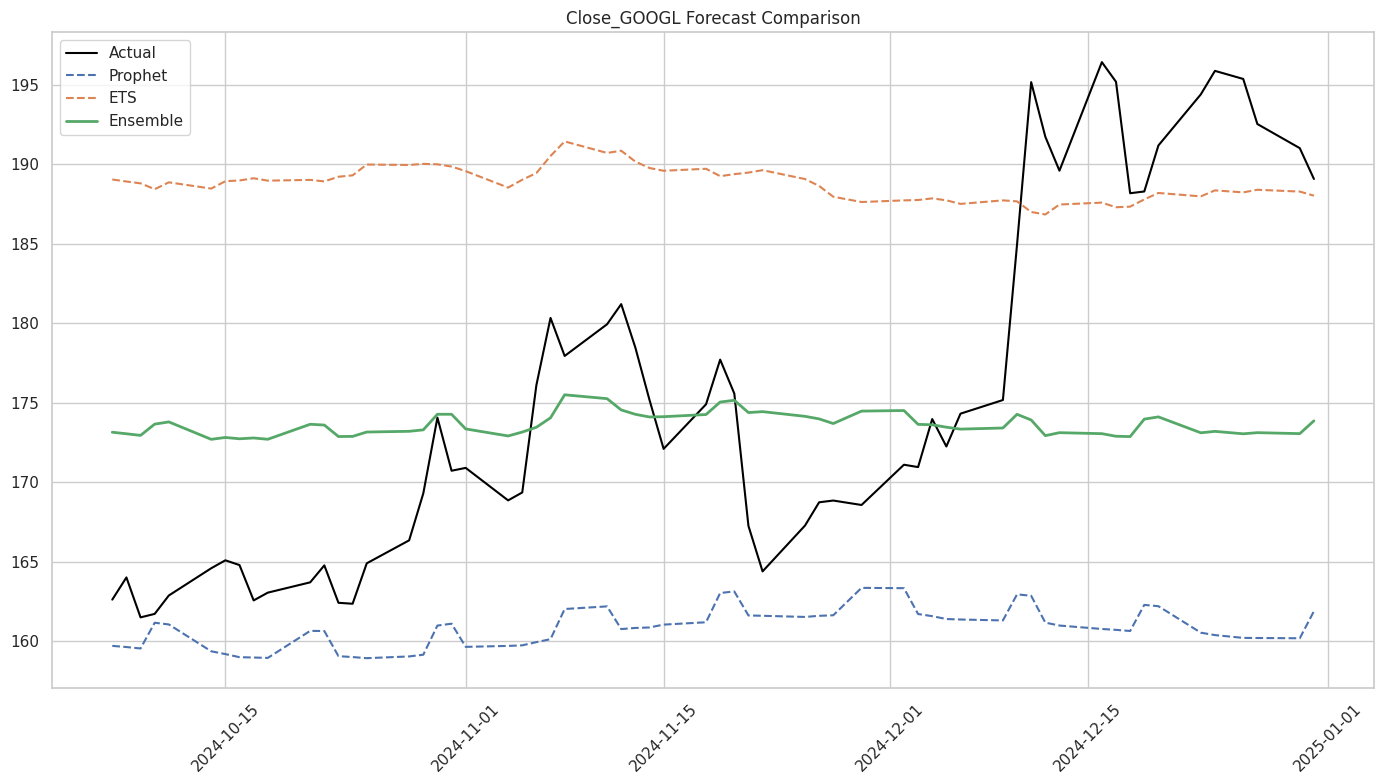

Ensemble MAPE: 0.0496, Ensemble RMSE: 11.0884


In [53]:
### Step 11: Model Comparison and Ensemble

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Evaluate models on last 60 days
metrics = []
for ticker in tickers:
    try:
        actual = df_long[df_long['Ticker'] == ticker].iloc[-60:]['Close'].values

        # Prophet forecast
        prophet_fcst = prophet_forecasts[ticker].iloc[-60:]['yhat'].values

        # ETS forecast
        ets_fcst = ets_forecasts[ticker][-60:].values

        # Calculate metrics
        prophet_mape = mean_absolute_percentage_error(actual, prophet_fcst)
        ets_mape = mean_absolute_percentage_error(actual, ets_fcst)
        prophet_rmse = np.sqrt(mean_squared_error(actual, prophet_fcst))
        ets_rmse = np.sqrt(mean_squared_error(actual, ets_fcst))

        metrics.append({
            'Ticker': ticker,
            'Prophet_MAPE': prophet_mape,
            'ETS_MAPE': ets_mape,
            'Prophet_RMSE': prophet_rmse,
            'ETS_RMSE': ets_rmse
        })
    except KeyError as e:
        print(f"Skipping {ticker} due to missing forecast data: {e}")

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Select GOOGL (fix name if needed)
target_ticker = 'Close_GOOGL'  # update this if the format is different in your forecasts

if target_ticker not in prophet_forecasts or target_ticker not in ets_forecasts:
    raise KeyError(f"Forecasts for '{target_ticker}' are missing in prophet_forecasts or ets_forecasts.")

# Extract data for the selected ticker
googl_actual = df_long[df_long['Ticker'] == target_ticker].iloc[-60:]['Close'].values
googl_dates = df_long[df_long['Ticker'] == target_ticker].iloc[-60:]['Date'].values

prophet_fcst = prophet_forecasts[target_ticker].iloc[-60:]['yhat'].values
ets_fcst = ets_forecasts[target_ticker][-60:].values

# Get MAPE scores for weighting
prophet_mape = metrics_df[metrics_df['Ticker'] == target_ticker]['Prophet_MAPE'].values[0]
ets_mape = metrics_df[metrics_df['Ticker'] == target_ticker]['ETS_MAPE'].values[0]

# Compute weights (inverse MAPE)
w_prophet = (1 / prophet_mape) / ((1 / prophet_mape) + (1 / ets_mape))
w_ets = (1 / ets_mape) / ((1 / prophet_mape) + (1 / ets_mape))

# Create ensemble
ensemble = w_prophet * prophet_fcst + w_ets * ets_fcst

# Plot comparison
plt.figure(figsize=(14, 8))
plt.plot(googl_dates, googl_actual, label='Actual', color='black')
plt.plot(googl_dates, prophet_fcst, label='Prophet', linestyle='--')
plt.plot(googl_dates, ets_fcst, label='ETS', linestyle='--')
plt.plot(googl_dates, ensemble, label='Ensemble', linewidth=2)
plt.title(f'{target_ticker} Forecast Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print ensemble metrics
ensemble_mape = mean_absolute_percentage_error(googl_actual, ensemble)
ensemble_rmse = np.sqrt(mean_squared_error(googl_actual, ensemble))
print(f"Ensemble MAPE: {ensemble_mape:.4f}, Ensemble RMSE: {ensemble_rmse:.4f}")


In [54]:
### Step 12: Risk Assessment and Portfolio Simulation
# GARCH modeling
garch_results = {}
for ticker in tickers:
    returns = df_returns[df_returns['Ticker'] == ticker]['log_return'].dropna()
    model = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='t')
    model_fit = model.fit(disp='off')
    forecast = model_fit.forecast(horizon=1)

    # Extract parameters
    sigma = np.sqrt(forecast.variance.values[-1, 0]) / 100
    nu = model_fit.params['nu']

    # Calculate VaR and ES
    var_95 = -sigma * np.sqrt((nu-2)/nu) * t.ppf(0.05, nu)
    es_95 = -sigma * np.sqrt((nu-2)/nu) * (t.pdf(t.ppf(0.05, nu), nu) / 0.05) * (nu + t.ppf(0.05, nu)**2) / (nu-1)

    garch_results[ticker] = {
        'sigma': sigma,
        'VaR_95': var_95,
        'ES_95': es_95
    }

risk_df = pd.DataFrame(garch_results).T.reset_index().rename(columns={'index': 'Ticker'})
print(risk_df)

          Ticker     sigma    VaR_95     ES_95
0     Close_AAPL  0.013205  0.020465 -0.029666
1     Close_AMZN  0.018196  0.027804 -0.041086
2    Close_GOOGL  0.019694  0.029483 -0.044644
3     Close_MSFT  0.013936  0.021576 -0.031321
4     Close_NVDA  0.023149  0.035597 -0.052168
5      High_AAPL  0.011279  0.016901 -0.025565
6      High_AMZN  0.016765  0.023652 -0.037869
7     High_GOOGL  0.018528  0.026711 -0.041990
8      High_MSFT  0.012355  0.018262 -0.028032
9      High_NVDA  0.023238  0.034137 -0.052724
10      Low_AAPL  0.014308  0.021410 -0.032436
11      Low_AMZN  0.018275  0.026473 -0.041436
12     Low_GOOGL  0.018236  0.026893 -0.041374
13      Low_MSFT  0.013323  0.020010 -0.030189
14      Low_NVDA  0.023321  0.035123 -0.052825
15     Open_AAPL  0.014034  0.021572 -0.031630
16     Open_AMZN  0.018602  0.028079 -0.042119
17    Open_GOOGL  0.021019  0.032128 -0.047457
18     Open_MSFT  0.013090  0.020269 -0.029419
19     Open_NVDA  0.026068  0.040704 -0.058345
20   Volume_A

In [55]:
### Step 13: Portfolio Optimization
# Calculate covariance matrix
cov_matrix = ret_wide.drop(columns='Date').cov() * 252  # Annualize

# Portfolio weights strategies
def get_weights(cov_matrix, risk_df, df_long):
    tickers = cov_matrix.columns

    # 1. Equal weighting
    w_equal = np.ones(len(tickers)) / len(tickers)

    # 2. Inverse risk weighting
    risk_vals = risk_df.set_index('Ticker')['sigma']
    w_inv_risk = 1 / risk_vals
    w_inv_risk /= w_inv_risk.sum()

    # 3. Return-based weighting
    returns = df_long.groupby('Ticker').apply(
        lambda x: x['Close'].iloc[-1] / x['Close'].iloc[0] - 1)
    w_return = returns / returns.sum()

    # 4. Mean-variance optimization
    mu = ret_wide[tickers].mean() * 252  # Annual returns
    n = len(tickers)

    def portfolio_volatility(w, cov_matrix):
        return np.sqrt(w.T @ cov_matrix @ w)

    def portfolio_return(w, mu):
        return w.T @ mu

    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum to 1
        {'type': 'ineq', 'fun': lambda w: w}              # Non-negative
    )

    bounds = [(0, 0.3) for _ in range(n)]  # Max 30% per asset

    # Maximize return for fixed volatility (15%)
    result = minimize(
        lambda w: -portfolio_return(w, mu),
        x0=w_equal,
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )

    w_mv = result.x

    return {
        'Equal': w_equal,
        'InverseRisk': w_inv_risk.values,
        'ReturnBased': w_return.values,
        'MV_Optim': w_mv
    }, tickers

weights_dict, tickers = get_weights(cov_matrix, risk_df, df_long)

# Create weights DataFrame
weights_df = pd.DataFrame(weights_dict, index=tickers)
print(weights_df)

              Equal  InverseRisk  ReturnBased      MV_Optim
Ticker                                                     
Close_AAPL     0.04     0.061845     0.022620  5.245504e-16
Close_AMZN     0.04     0.044883     0.018991  1.343117e-16
Close_GOOGL    0.04     0.041468     0.006643  0.000000e+00
Close_MSFT     0.04     0.058602     0.010216  0.000000e+00
Close_NVDA     0.04     0.035278     0.188766  1.000000e-01
High_AAPL      0.04     0.072407     0.022832  0.000000e+00
High_AMZN      0.04     0.048712     0.018938  5.721521e-17
High_GOOGL     0.04     0.044077     0.006713  0.000000e+00
High_MSFT      0.04     0.066099     0.010297  3.143974e-16
High_NVDA      0.04     0.035144     0.192737  3.000000e-01
Low_AAPL       0.04     0.057078     0.022706  1.852135e-16
Low_AMZN       0.04     0.044688     0.019062  1.461542e-16
Low_GOOGL      0.04     0.044784     0.006642  1.585639e-16
Low_MSFT       0.04     0.061299     0.010321  5.055225e-17
Low_NVDA       0.04     0.035018     0.1

<ipython-input-55-38cd6bf0c337>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns = df_long.groupby('Ticker').apply(


In [56]:
### Step 14: Portfolio Simulation
def simulate_portfolio(weights, cov_matrix, n_sims=5000, horizon=252):
    """Simulate portfolio returns over given horizon"""
    # Generate correlated returns
    L = np.linalg.cholesky(cov_matrix)
    uncorrelated = np.random.normal(size=(n_sims, horizon, len(weights)))
    correlated = uncorrelated @ L.T

    # Calculate cumulative returns
    cumulative_returns = np.exp(np.sum(correlated, axis=1)) - 1

    # Apply weights
    portfolio_returns = cumulative_returns @ weights

    return portfolio_returns

# Define horizons
horizons = {
    '1m': 21,
    '6m': 126,
    '1y': 252,
    '5y': 1260,
    '10y': 2520
}

# Run simulations
results = []
for strategy, w in weights_dict.items():
    for horizon_name, days in horizons.items():
        sim_returns = simulate_portfolio(w, cov_matrix.values / 252, horizon=days)

        results.append({
            'Strategy': strategy,
            'Horizon': horizon_name,
            'MeanReturn': np.mean(sim_returns),
            'SDReturn': np.std(sim_returns),
            'Pct5': np.percentile(sim_returns, 5),
            'Pct95': np.percentile(sim_returns, 95)
        })

results_df = pd.DataFrame(results)
print(results_df)

# Find top strategies by horizon
top_strategies = results_df.loc[results_df.groupby('Horizon')['MeanReturn'].idxmax()]
print("\nTop performing strategies by horizon:")
print(top_strategies[['Horizon', 'Strategy', 'MeanReturn']])


       Strategy Horizon    MeanReturn      SDReturn          Pct5  \
0         Equal      1m  4.792446e-01  1.249055e+00 -1.526695e-01   
1         Equal      6m  1.653438e+02  2.322238e+03 -2.167744e-01   
2         Equal      1y  2.269841e+04  8.527745e+05 -2.235016e-01   
3         Equal      5y  1.658973e+14  6.212651e+15 -2.353249e-01   
4         Equal     10y  2.333587e+23  1.345970e+25 -1.426986e-01   
5   InverseRisk      1m  3.555749e-02  8.938869e-02 -7.317591e-02   
6   InverseRisk      6m  8.135292e+00  8.272289e+01 -1.348656e-01   
7   InverseRisk      1y  7.830242e+03  4.111116e+05 -1.351242e-01   
8   InverseRisk      5y  9.147518e+15  6.403678e+17 -1.858795e-01   
9   InverseRisk     10y  2.466855e+23  1.695110e+25 -1.342281e-01   
10  ReturnBased      1m  1.927468e-03  9.245201e-02 -1.424391e-01   
11  ReturnBased      6m -2.872697e+00  4.364494e+01 -2.973828e+00   
12  ReturnBased      1y -4.757451e+02  1.486865e+04 -9.655340e+01   
13  ReturnBased      5y -1.770901e

In [59]:
# Save as CSV
metrics_df.to_csv('model_metrics.csv', index=False)

# Download to your computer
from google.colab import files
files.download('model_metrics.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>